In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as sps
import seaborn as sns
sns.set(style='ticks', font_scale=1.3)

import scipy.optimize

rcParams['figure.figsize'] = 10, 5

from typing import Optional, Union, List, Tuple, Any, Callable

In [2]:
import logging

logger = logging.getLogger(__name__)
loglevel = "DEBUG"
logger.setLevel(loglevel)
handler = logging.StreamHandler()
handler.setLevel(loglevel)
format = '%(levelname)s: %(message)s'
handler.setFormatter(logging.Formatter(format))
logger.addHandler(handler)

## Task 2: Gradient descent

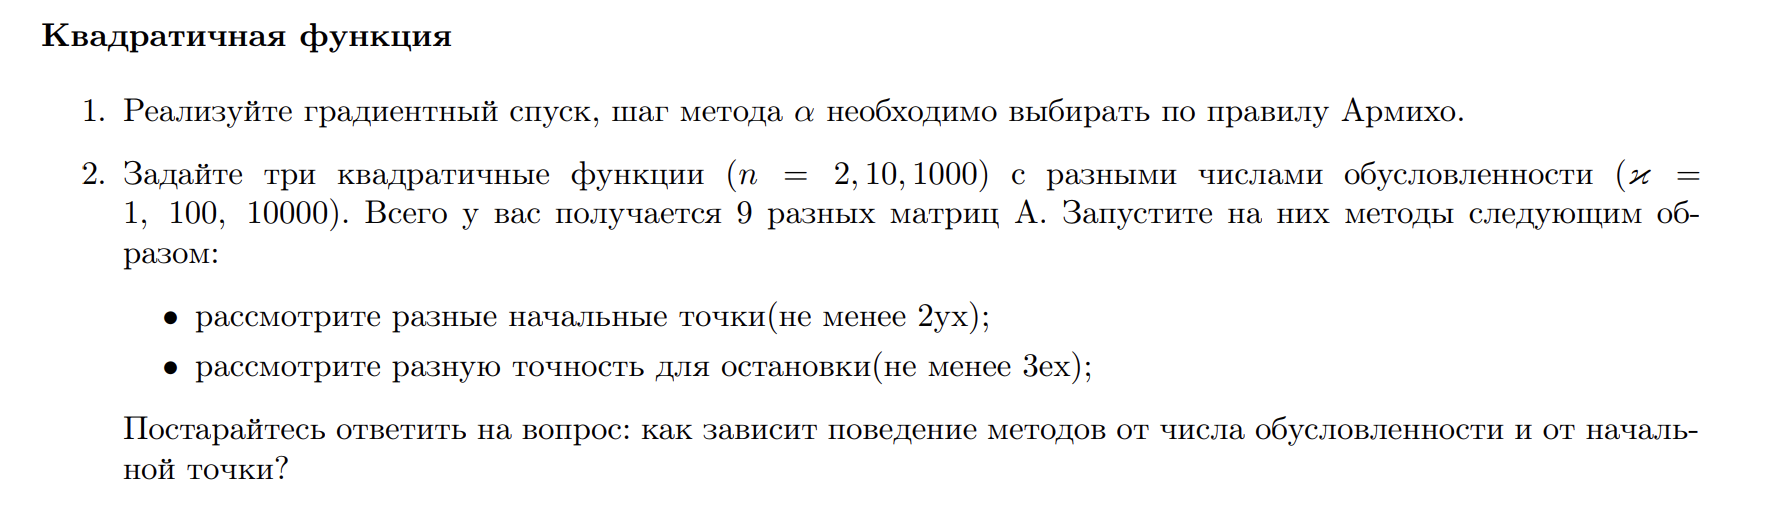

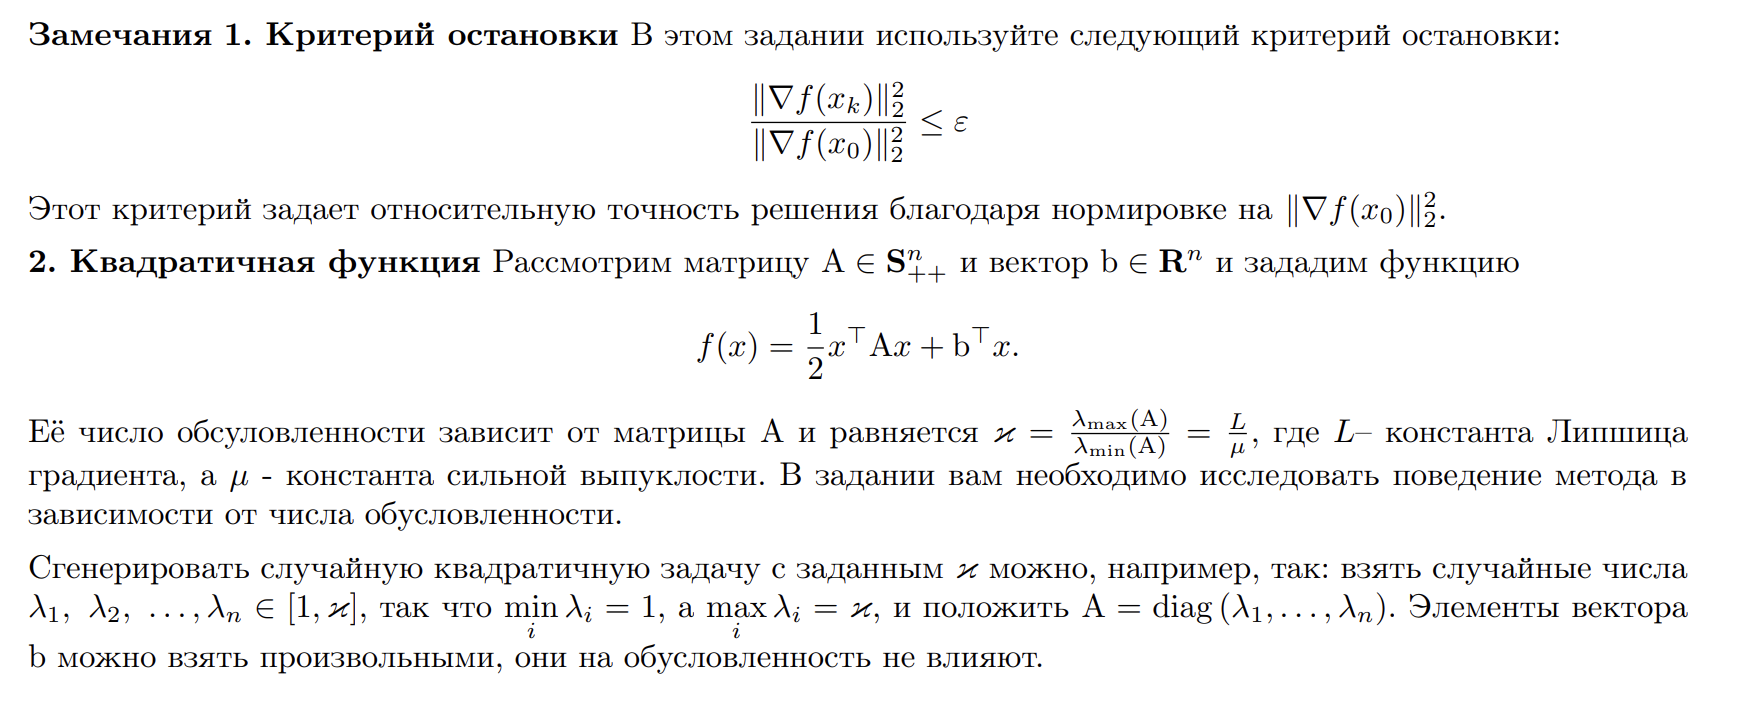

### Functions

In [3]:
def f_quadratic(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f_quadratic(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

In [4]:
def quadratic_func_params(n: int, cond_num: int) -> Tuple[np.ndarray, np.ndarray]:
    """ 
    Generate parameters for quadratic function f(x) = (1/2) * (x.T @ A @ x) + (b.T @ x)
    
    :param n: dimension of x
    :param cond_num: condition number of matrix A
    :return: A, b
    """
    lambdas = sps.uniform(loc=1, scale=cond_num).rvs(size=n)
    lambdas[np.argmin(lambdas)] = 1
    lambdas[np.argmax(lambdas)] = cond_num

    A = np.diagflat(lambdas)
    b = np.random.rand(n) * 5
    
    return A, b

In [5]:
def draw_convergence_plot(f_vals: np.ndarray, N_iterations: int, label: Optional[str] = None):

    plt.plot(np.arange(N_iterations), f_vals[:N_iterations], lw=3, label=label)

    plt.ylabel("Function value")
    plt.xlabel("Number of iteration")
    if label is not None: plt.legend()
    plt.grid()

In [6]:
def draw_alpha_plot(alphas: np.ndarray, N_iterations: int):
    
    plt.plot(np.arange(N_iterations), alphas[:N_iterations], lw=3)

    plt.ylabel("Step alpha")
    plt.xlabel("Number of iteration")
    plt.grid()

### Grad descent

In [7]:
def gradient_descent(n: int, N: int, alpha: float, eps: float,
                     f: Callable, grad_f: Callable,
                     params: Tuple[Any, ...] = (),
                     x0: Optional[np.ndarray] = None, 
                     verbose: bool = False):
    """ 
    Gradient method
    
    :param n: dimension of x
    :param N: max number of iterations
    :param alpha: initial gradient step
    :param eps: tolerance
    :param f: objective function
    :param grad_f: gradient of objective function
    :param params: objective function arguments
    :param x0: initial guess of x
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    if x0 is None:
        x0 = np.random.rand(n)
    
    x = np.zeros((N, n))
    x[0] = x0
    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], *params)
    alphas = np.zeros(N)

    norm_0 = np.linalg.norm(grad_f(x[0], *params))
    
    end_iteration = N
    
    for k in range(N-1): 
        
        h_k = grad_f(x[k], *params)
        
        # Armijo rule
        while f(x[k] - alpha * h_k, *params) > f(x[k], *params) + 0.2 * alpha * (h_k @ h_k):
            alpha_new = alpha * 0.5
            logger.debug(f"iteration: {k}; Armijo condition is not true, change alpha from {alpha:.6f} to {alpha_new:.6f}")
            alpha = alpha_new
        
        alphas[k] = alpha
        
        # GD step
        x[k+1] = x[k] - alpha * h_k
                
        f_vals[k] = f(x[k], *params)
        f_vals[k+1] = f(x[k+1], *params)
        
        norm_k = np.linalg.norm(grad_f(x[k+1], *params))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        if stop_criteria:
            end_iteration = k+1
            logger.info(f'GD converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x[k+1]}')
            break


    if not stop_criteria:
        logger.info(f'(!) GD didnt converge, may be need to increase number of iterations N')
        logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
        
        
    return f_vals, x, end_iteration, alphas

Пример: градиентный спуск

Задаем матрицу А и столбец b в функции f(x)

In [8]:
n = 2
cond_num = 100

A, b = quadratic_func_params(n, cond_num)
params = (A, b)
params

(array([[100.,   0.],
        [  0.,   1.]]),
 array([3.27444571, 3.96511565]))

Запускаем град спуск

In [9]:
N = int(1e5)
alpha = 2
eps = 1e-10
x0 = np.random.rand(n)*5 + 10

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, 
                                                   f_quadratic, grad_f_quadratic,
                                                   params, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 2.000000 to 1.000000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 1.000000 to 0.500000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.500000 to 0.250000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.250000 to 0.125000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.125000 to 0.062500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.062500 to 0.031250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.031250 to 0.015625
INFO: GD converge at 446 iteration, min f(x) = -7.914594941696565
DEBUG: x_min = [-0.03274446 -3.95199257]


Сравним результат со scipy

In [10]:
scipy.optimize.minimize(f_quadratic, x0, args=(A, b))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -7.9146810493836925
        x: [-3.274e-02 -3.965e+00]
      nit: 3
      jac: [-4.172e-07  1.788e-07]
 hess_inv: [[ 1.000e-02 -2.067e-06]
            [-2.067e-06  1.000e+00]]
     nfev: 15
     njev: 5

Посмотрим на график сходимости метода

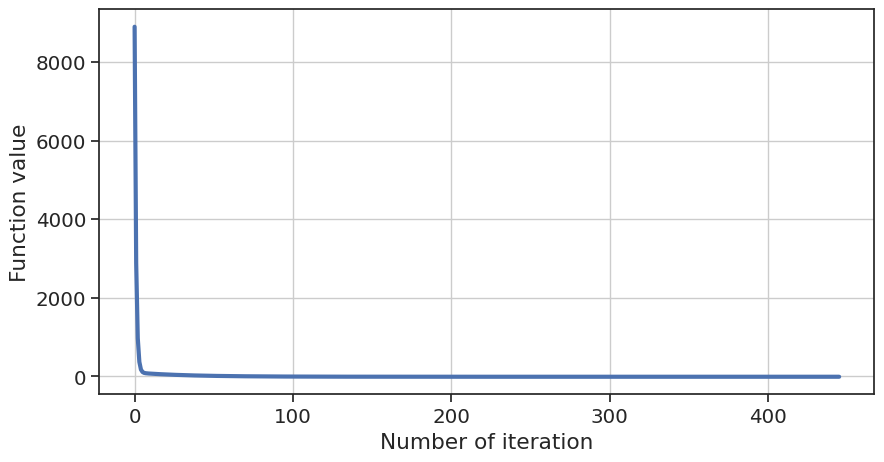

In [11]:
draw_convergence_plot(f_vals, N_iterations)

### Генерация 9 матриц с разными числами обусловленности

In [12]:
n_list = [2, 10, 1000]
cond_num_list = [1, 100, 1000]

A_list = []
b_list = []

for n in n_list:
    for cond_num in cond_num_list:        
        A, b = quadratic_func_params(n, cond_num)
        A_list.append(A)
        b_list.append(b)

#### Разные начальные точки

Начальная точка 1

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.1639960668369773


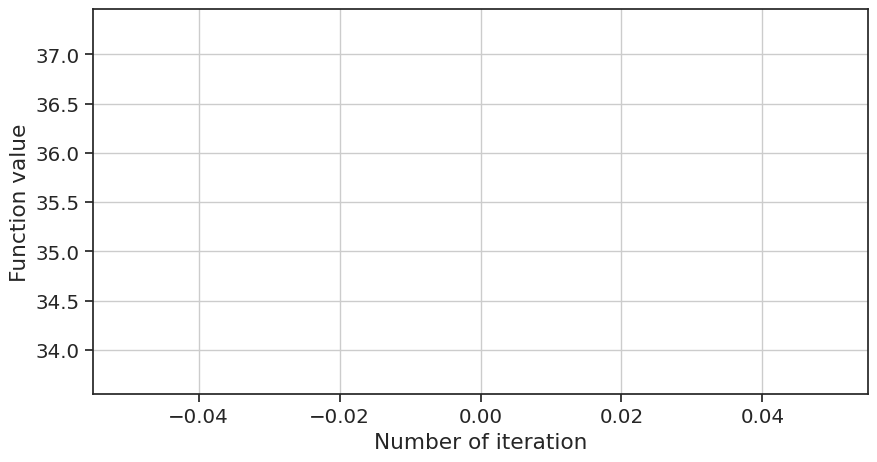

INFO: n = 2, condition number = 100
INFO: GD converge at 490 iteration, min f(x) = -0.22905628057491756


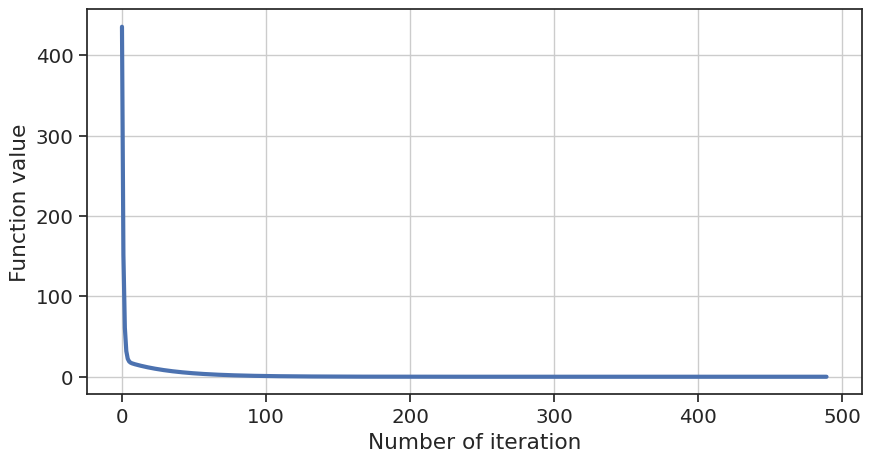

INFO: n = 2, condition number = 1000
INFO: GD converge at 2193 iteration, min f(x) = -0.8676524160826501


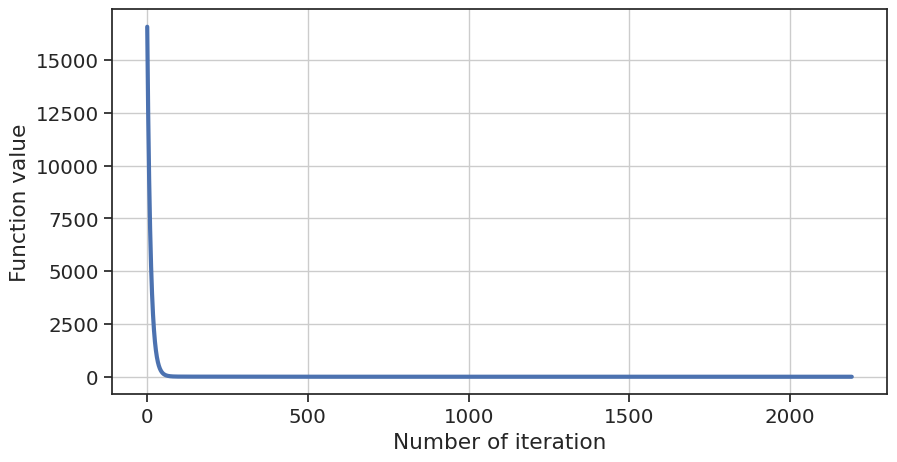

INFO: n = 10, condition number = 1
INFO: GD converge at 238 iteration, min f(x) = -43.90564718931484


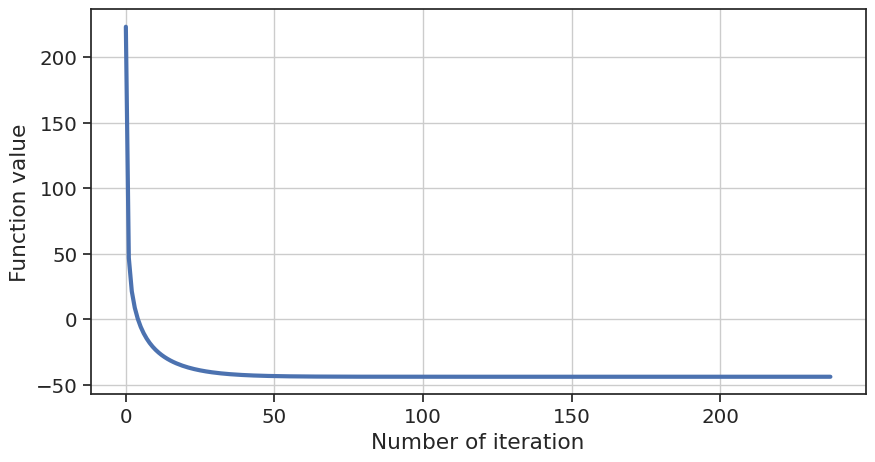

INFO: n = 10, condition number = 100
INFO: GD converge at 390 iteration, min f(x) = -4.854723050226354


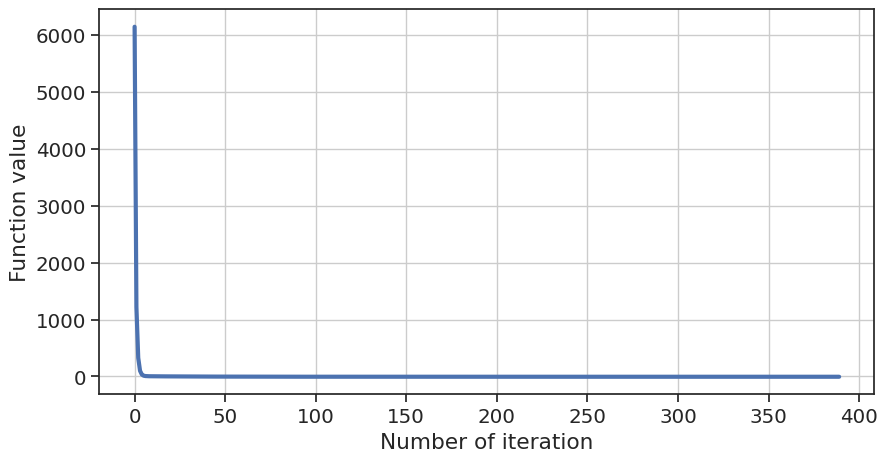

INFO: n = 10, condition number = 1000
INFO: GD converge at 2870 iteration, min f(x) = -11.13686170811301


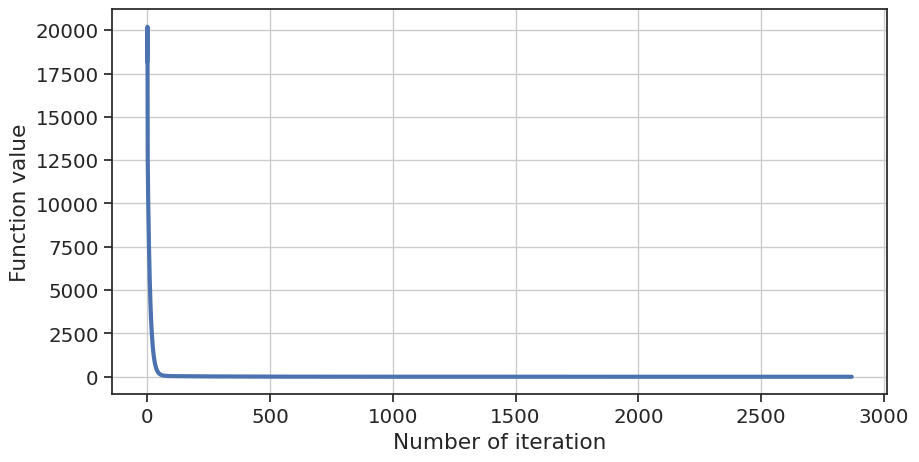

INFO: n = 1000, condition number = 1
INFO: GD converge at 4005 iteration, min f(x) = -2915.9456180882826


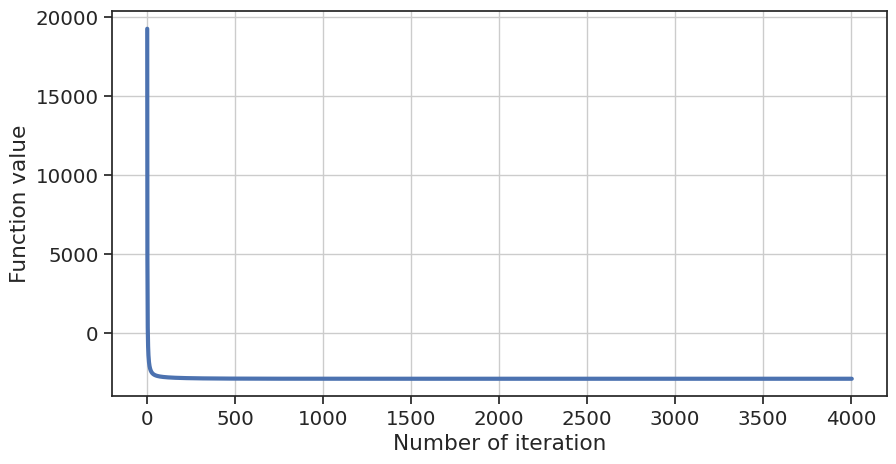

INFO: n = 1000, condition number = 100
INFO: GD converge at 292 iteration, min f(x) = -170.24941071563336


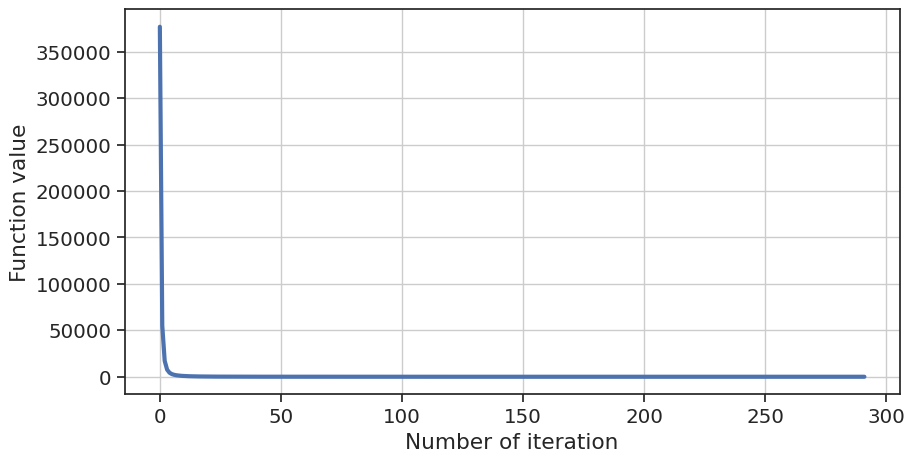

INFO: n = 1000, condition number = 1000
INFO: GD converge at 732 iteration, min f(x) = -26.859058937680555


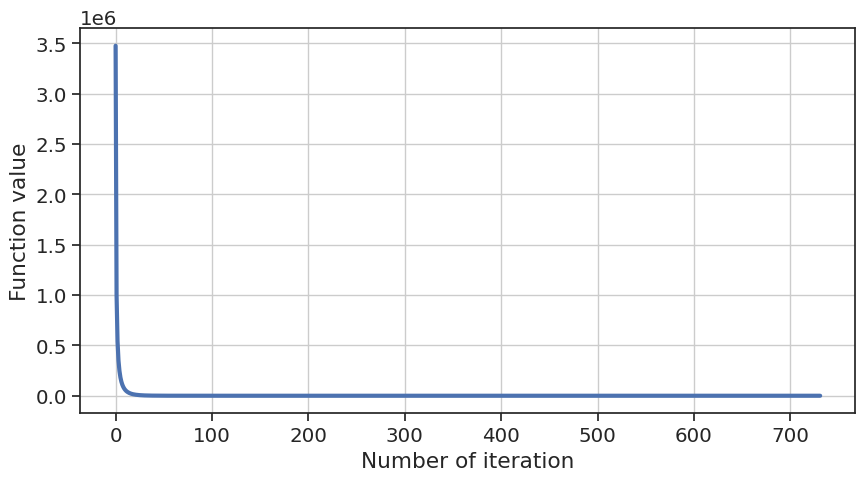

In [13]:
N = int(1e4)
eps = 1e-10


for A, b in zip(A_list, b_list):
    
    params = (A, b)
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, _ = gradient_descent(n, N, alpha, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    params, x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

Начальная точка 2

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.163996066836977


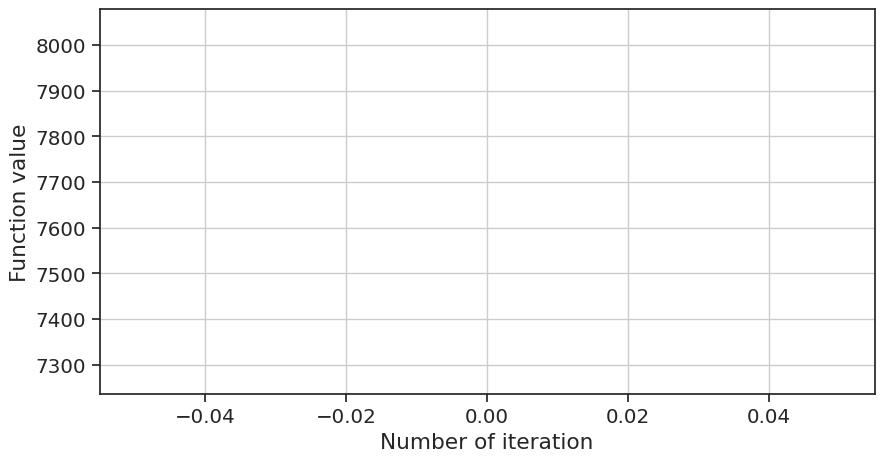

INFO: n = 2, condition number = 100
INFO: GD converge at 473 iteration, min f(x) = -0.22717979743200742


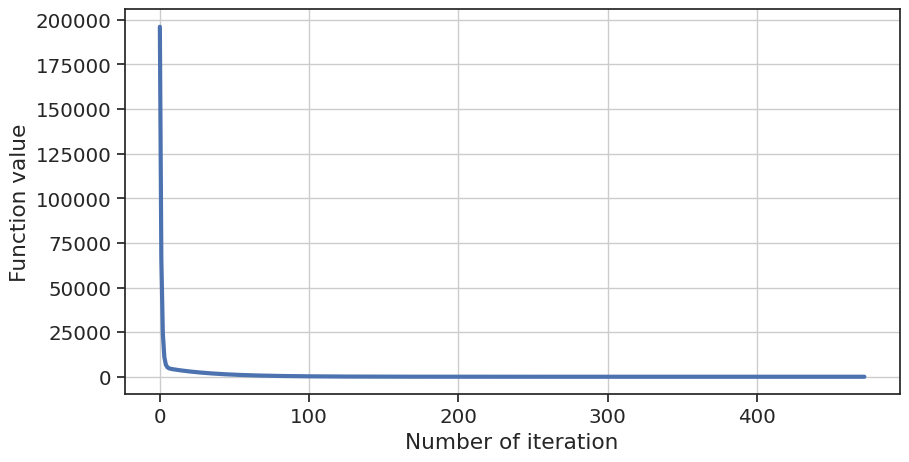

INFO: n = 2, condition number = 1000
INFO: GD converge at 2097 iteration, min f(x) = -0.3231996803648793


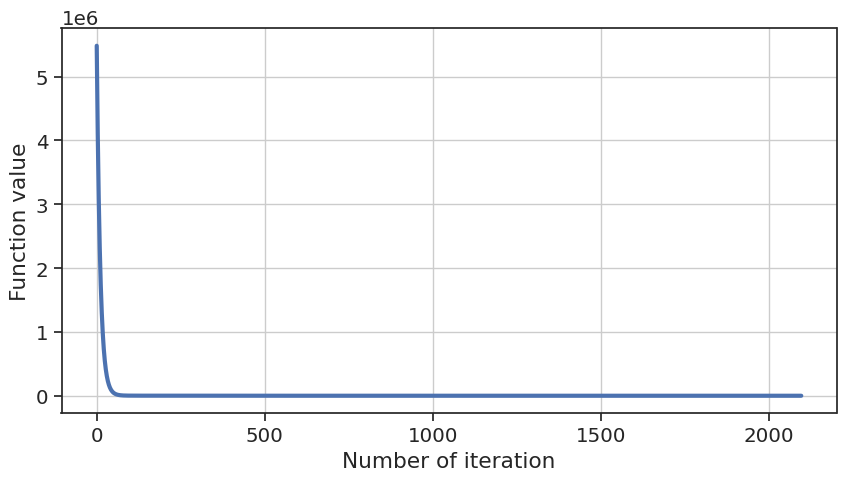

INFO: n = 10, condition number = 1
INFO: GD converge at 232 iteration, min f(x) = -43.90564514703182


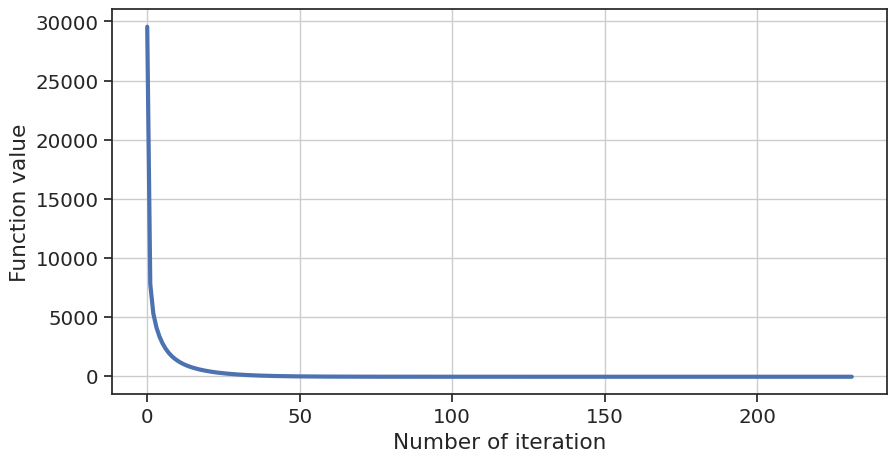

INFO: n = 10, condition number = 100
INFO: GD converge at 397 iteration, min f(x) = -4.842421125979872


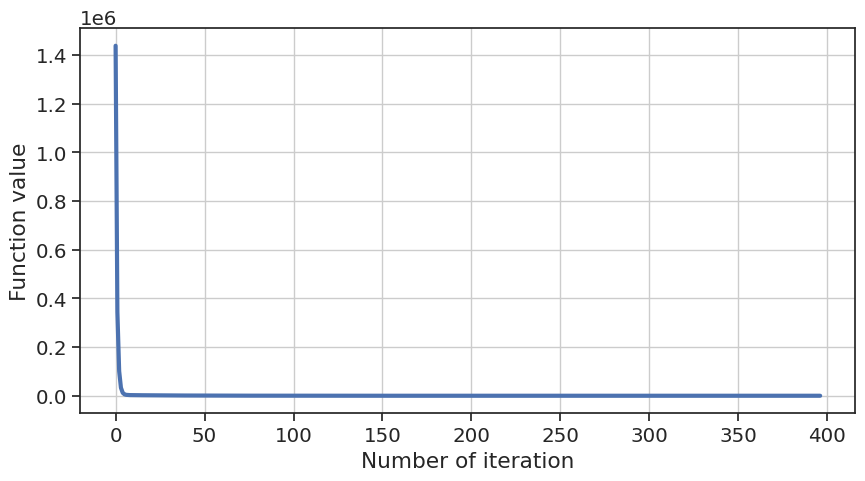

INFO: n = 10, condition number = 1000
INFO: GD converge at 2421 iteration, min f(x) = -10.674335192919102


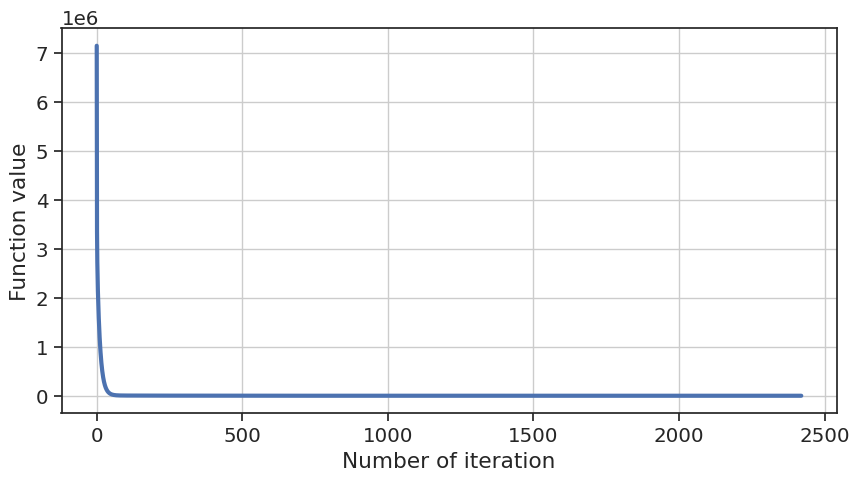

INFO: n = 1000, condition number = 1
INFO: GD converge at 3877 iteration, min f(x) = -2915.9453655422726


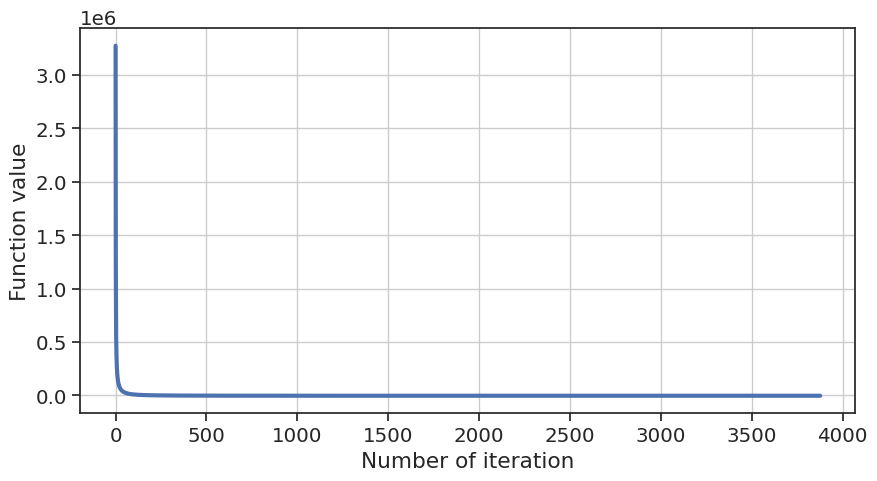

INFO: n = 1000, condition number = 100
INFO: GD converge at 272 iteration, min f(x) = -169.57745929397208


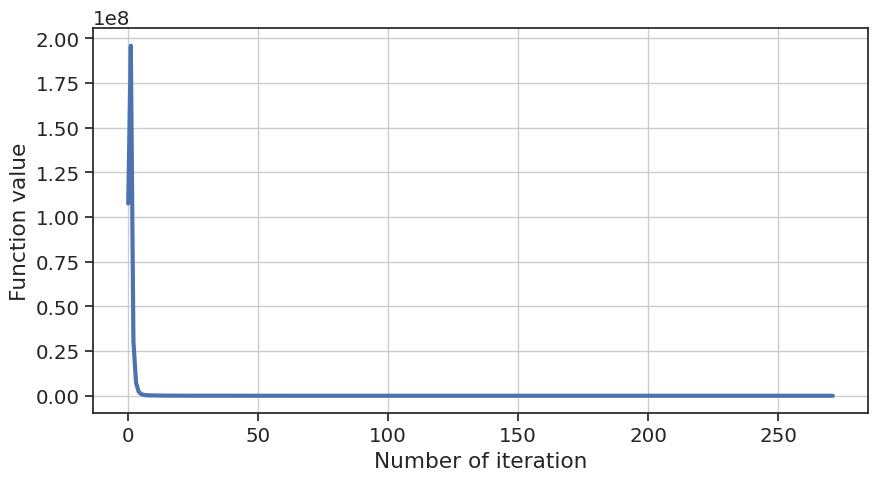

INFO: n = 1000, condition number = 1000
INFO: GD converge at 658 iteration, min f(x) = 18.27497522744764


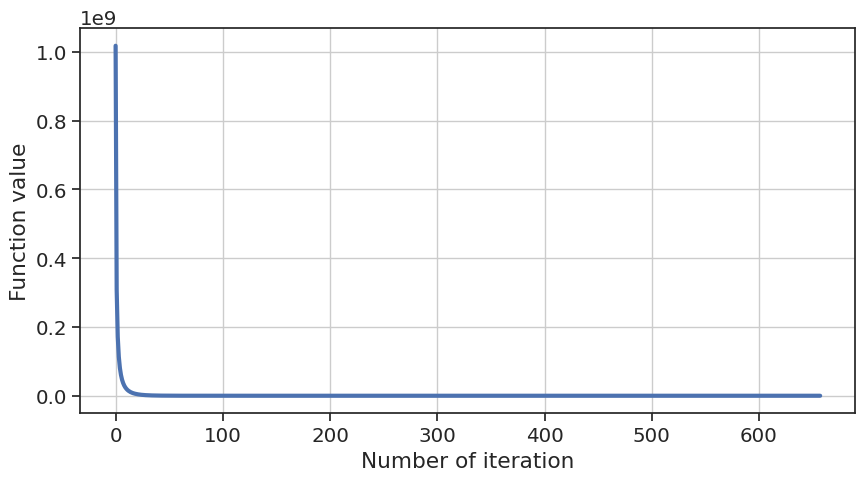

In [14]:
N = int(1e4)
eps = 1e-10


for A, b in zip(A_list, b_list):
    
    params = (A, b)
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=10, scale=100).rvs(n, random_state=23)
    
    f_vals, x, end_iteration, _ = gradient_descent(n, N, alpha, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    params, x0, verbose=False)
            
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

#### Разная точность для остановки eps

1) eps = $10^{-5}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.1639960668369773


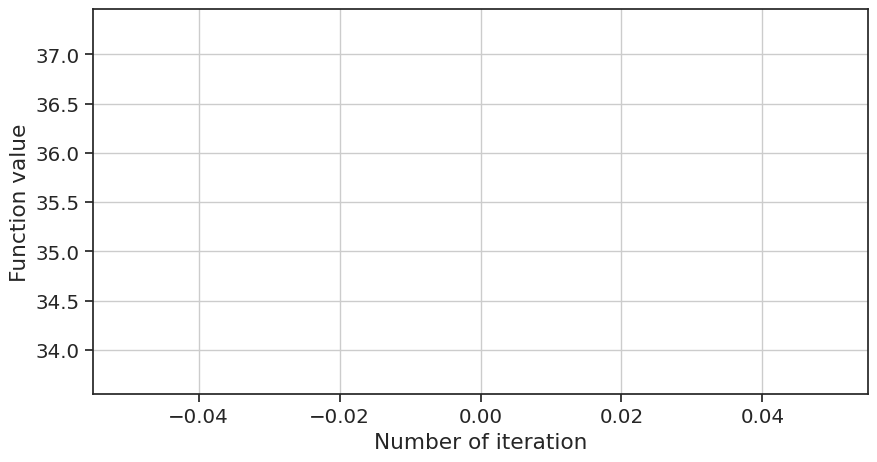

INFO: n = 2, condition number = 100
INFO: GD converge at 125 iteration, min f(x) = 0.17355376955576995


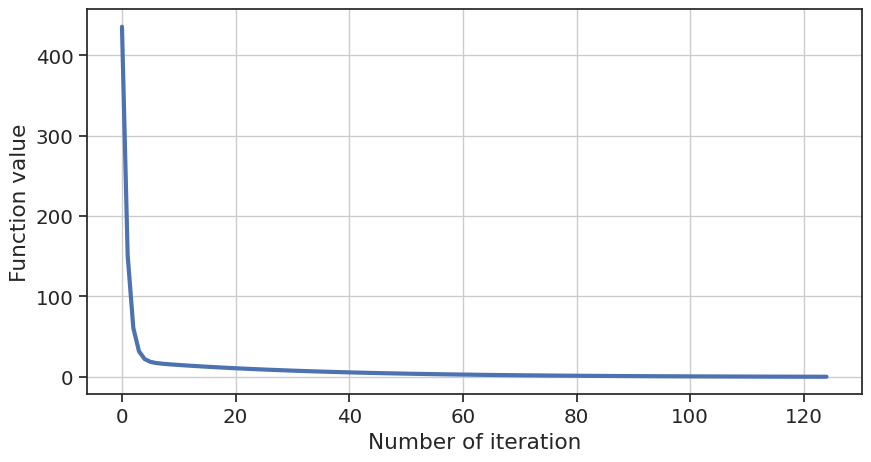

INFO: n = 2, condition number = 1000
INFO: GD converge at 121 iteration, min f(x) = 4.7374414006578185


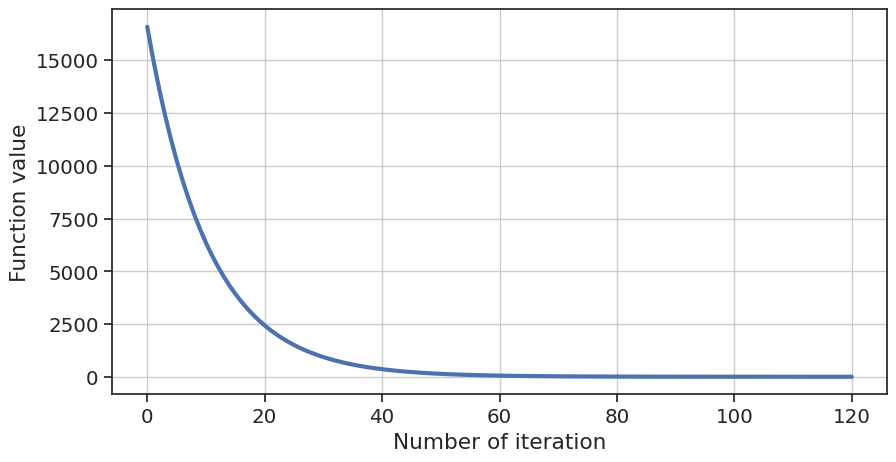

INFO: n = 10, condition number = 1
INFO: GD converge at 111 iteration, min f(x) = -43.90364831414191


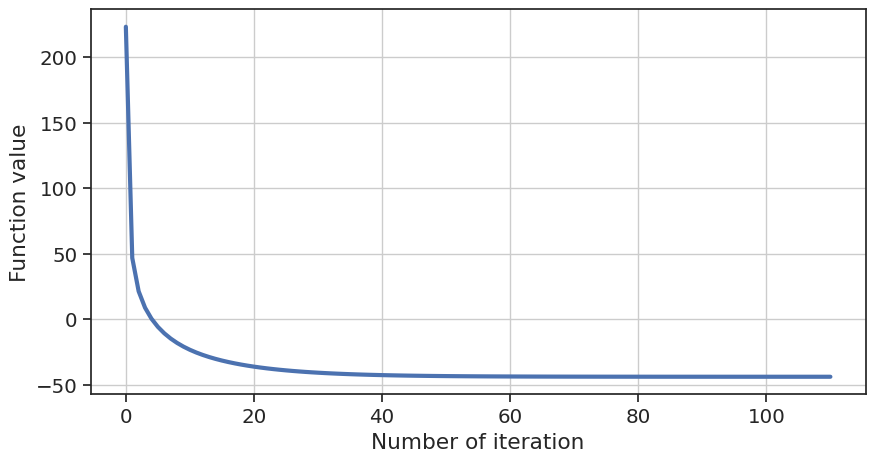

INFO: n = 10, condition number = 100
INFO: GD converge at 24 iteration, min f(x) = 0.4532964140209369


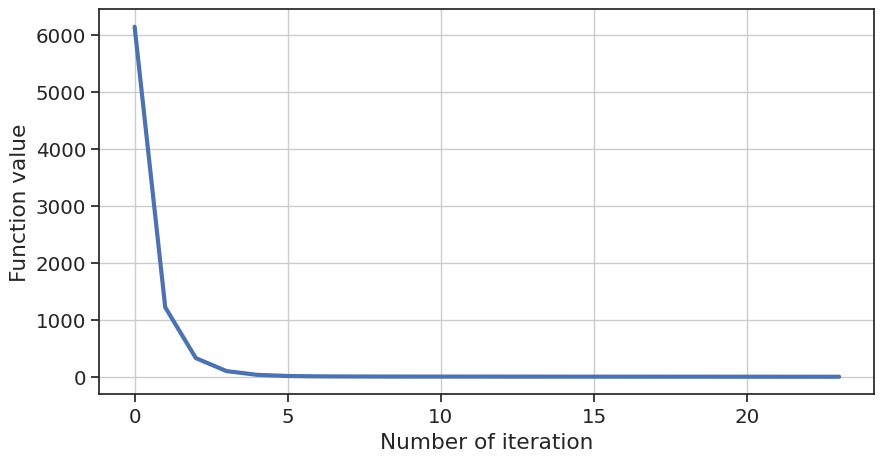

INFO: n = 10, condition number = 1000
INFO: GD converge at 134 iteration, min f(x) = 21.127633422554826


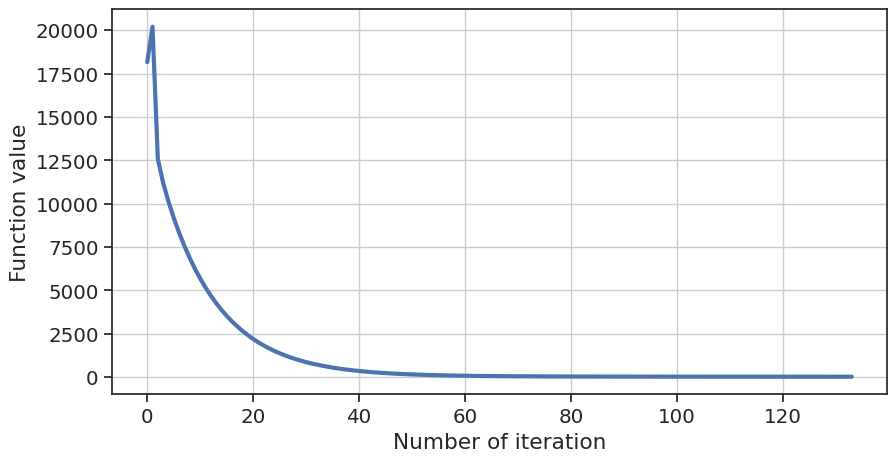

INFO: n = 1000, condition number = 1
INFO: GD converge at 1349 iteration, min f(x) = -2915.778104015221


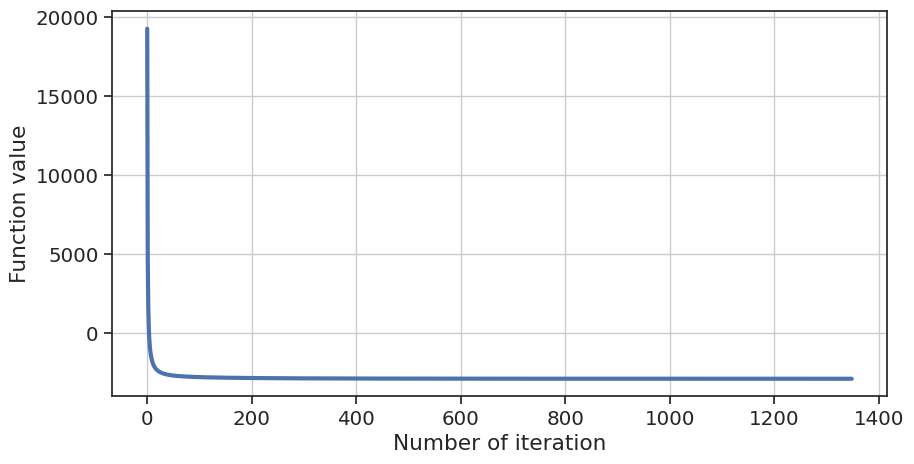

INFO: n = 1000, condition number = 100
INFO: GD converge at 28 iteration, min f(x) = -69.80503641043538


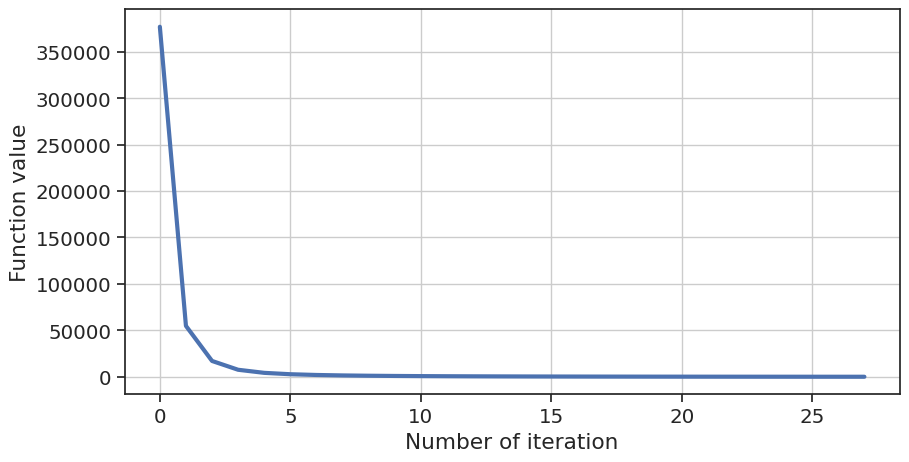

INFO: n = 1000, condition number = 1000
INFO: GD converge at 74 iteration, min f(x) = 82.0099814094458


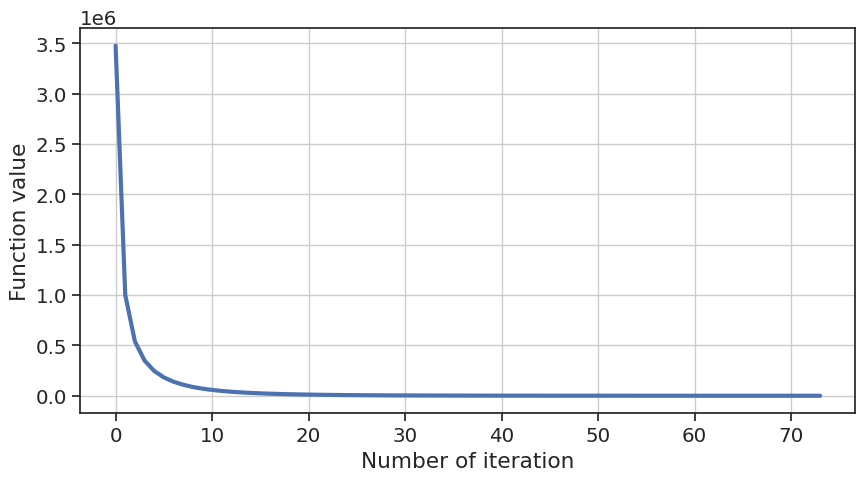

In [15]:
N = int(1e4)
eps = 1e-5


for A, b in zip(A_list, b_list):
    
    params = (A, b)
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, _ = gradient_descent(n, N, alpha, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    params, x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

2) eps = $10^{-8}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.1639960668369773


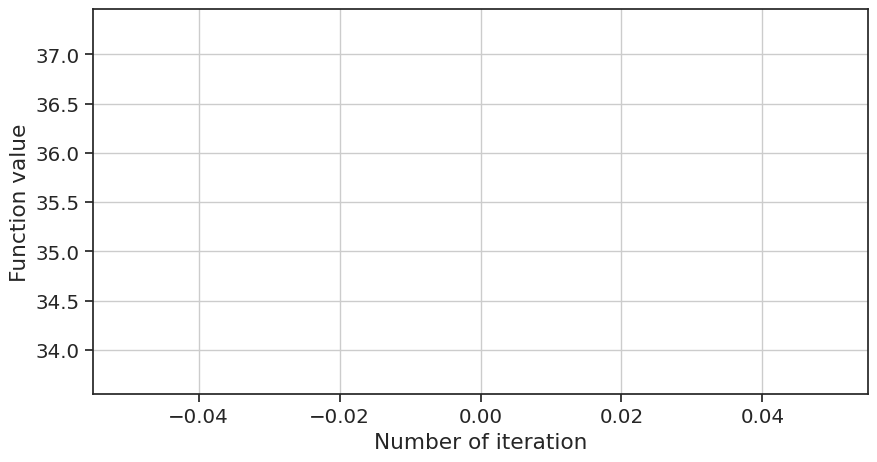

INFO: n = 2, condition number = 100
INFO: GD converge at 344 iteration, min f(x) = -0.22865372392286323


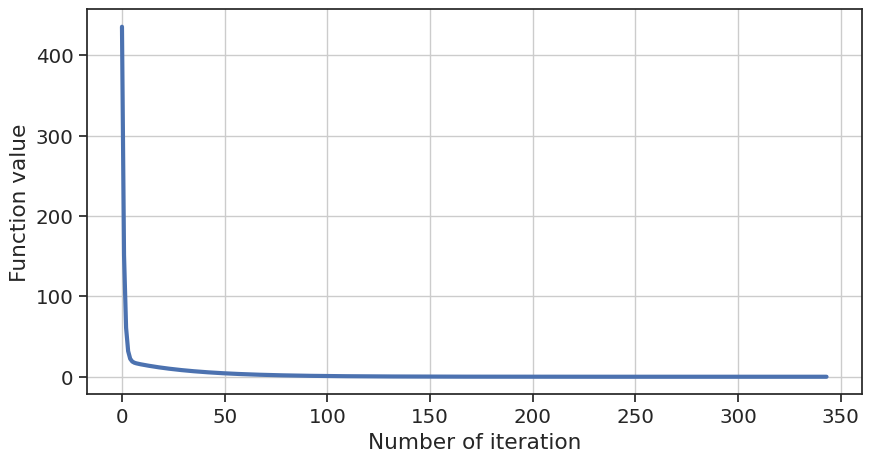

INFO: n = 2, condition number = 1000
INFO: GD converge at 1015 iteration, min f(x) = -0.7037754892074998


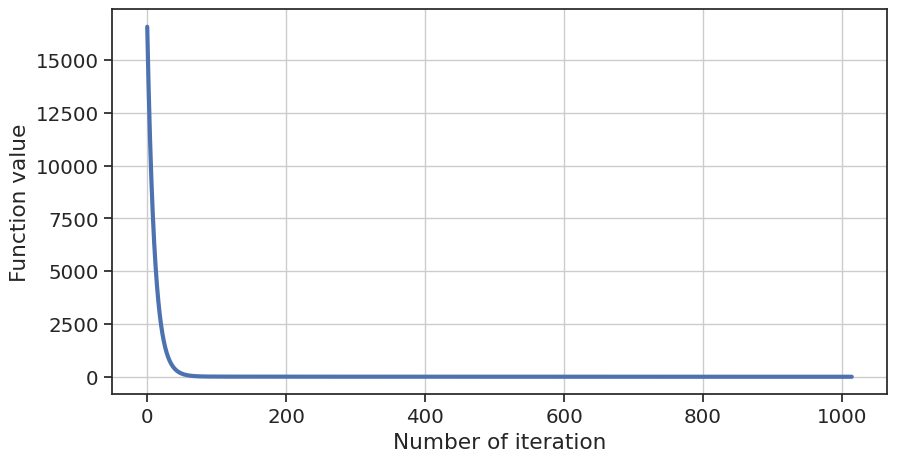

INFO: n = 10, condition number = 1
INFO: GD converge at 188 iteration, min f(x) = -43.90564535024305


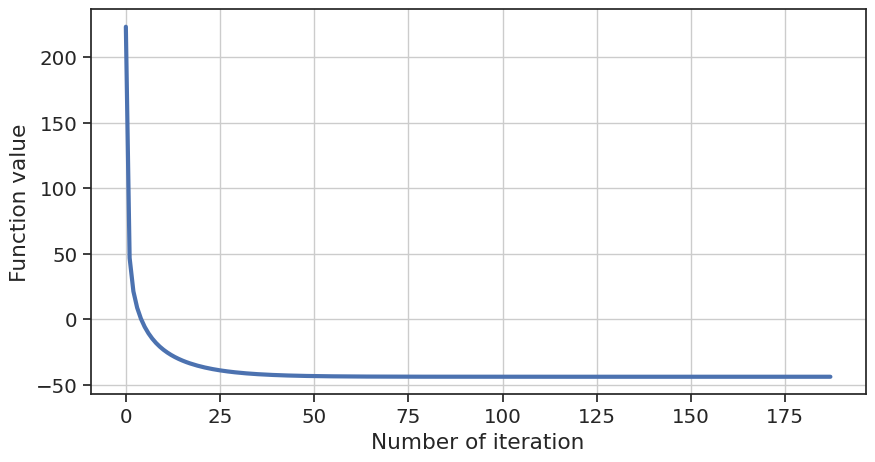

INFO: n = 10, condition number = 100
INFO: GD converge at 244 iteration, min f(x) = -4.849580294585145


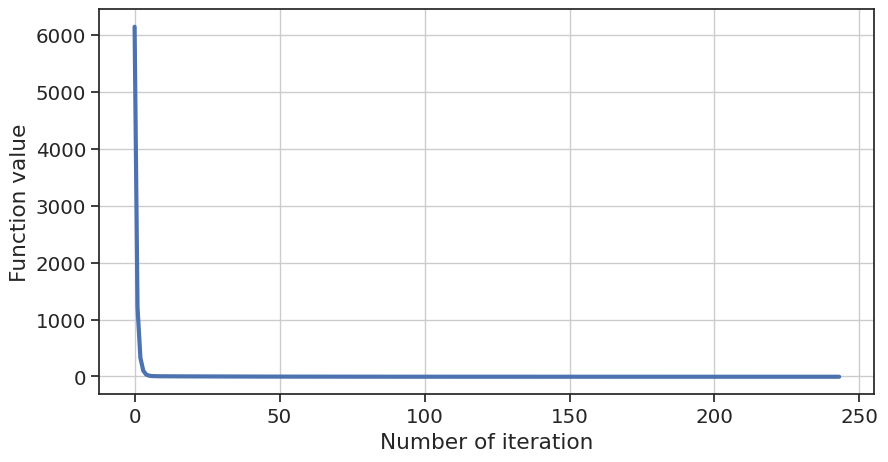

INFO: n = 10, condition number = 1000
INFO: GD converge at 1692 iteration, min f(x) = -11.064719843639786


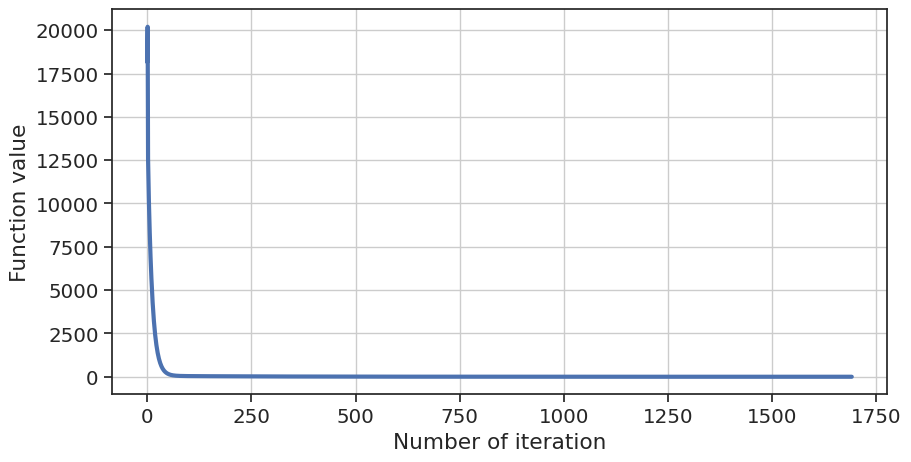

INFO: n = 1000, condition number = 1
INFO: GD converge at 2937 iteration, min f(x) = -2915.945451737923


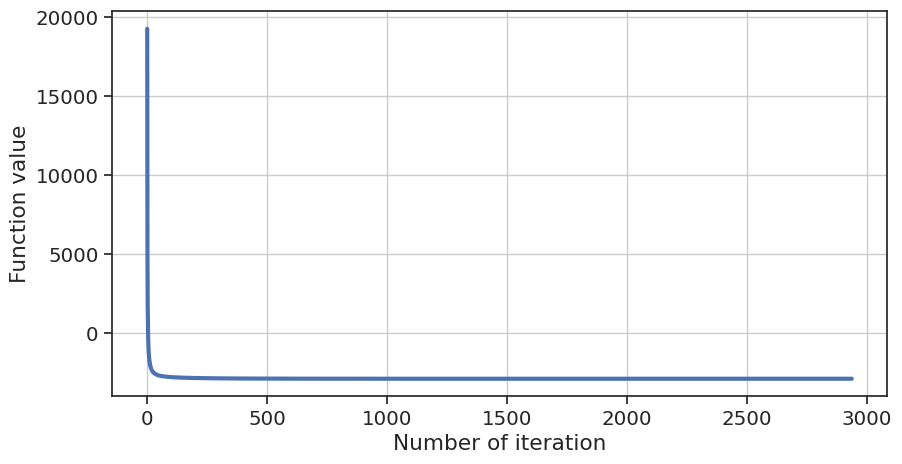

INFO: n = 1000, condition number = 100
INFO: GD converge at 168 iteration, min f(x) = -170.03975446187732


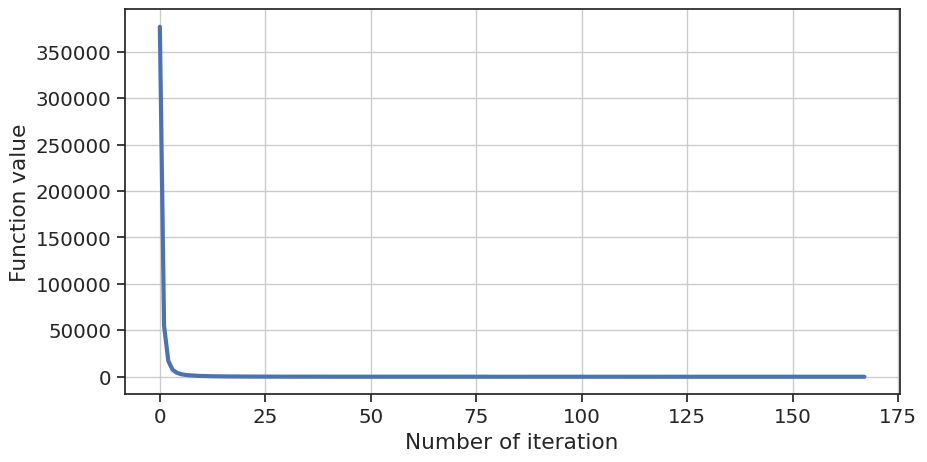

INFO: n = 1000, condition number = 1000
INFO: GD converge at 235 iteration, min f(x) = -19.227888605482242


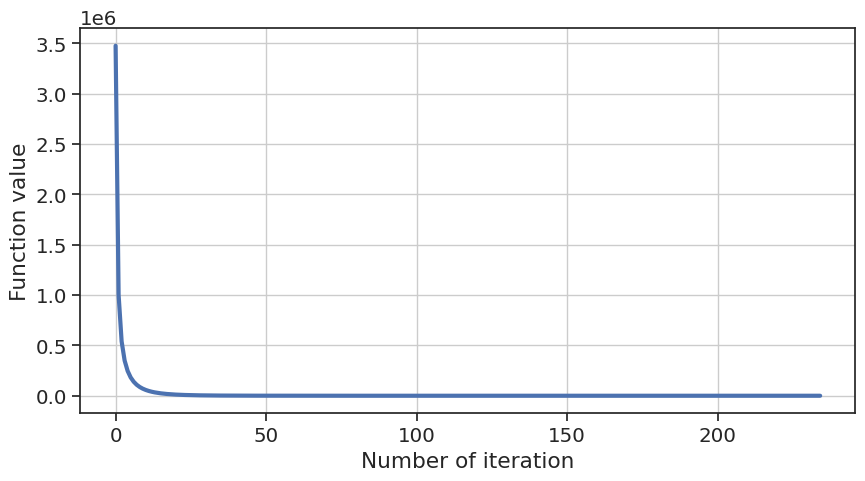

In [16]:
N = int(1e4)
eps = 1e-8


for A, b in zip(A_list, b_list):
    
    params = (A, b)
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, _ = gradient_descent(n, N, alpha, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    params, x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

3) eps = $10^{-12}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.1639960668369773


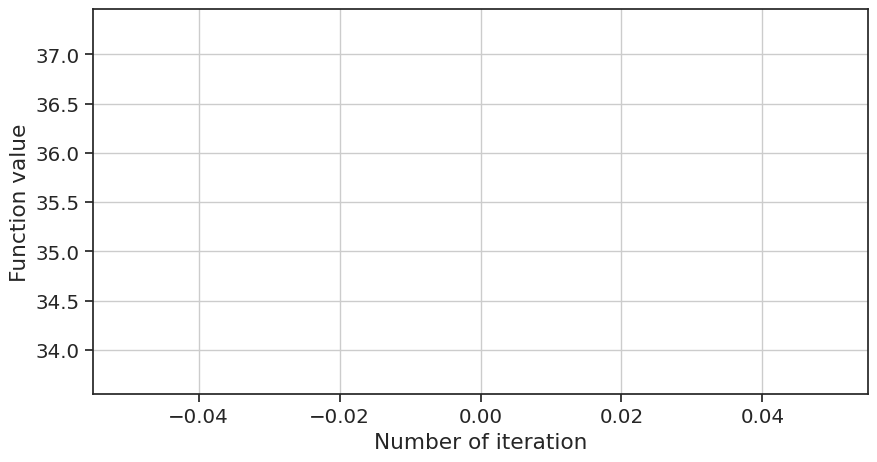

INFO: n = 2, condition number = 100
INFO: GD converge at 636 iteration, min f(x) = -0.22906033300046605


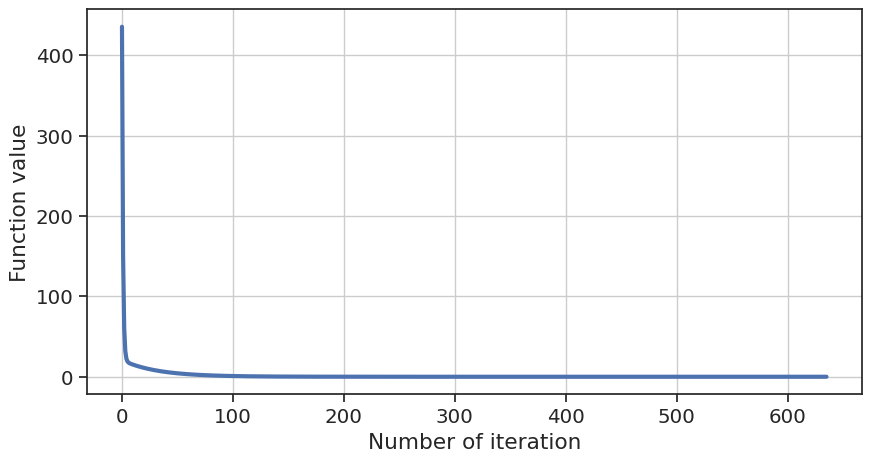

INFO: n = 2, condition number = 1000
INFO: GD converge at 3371 iteration, min f(x) = -0.869289724405721


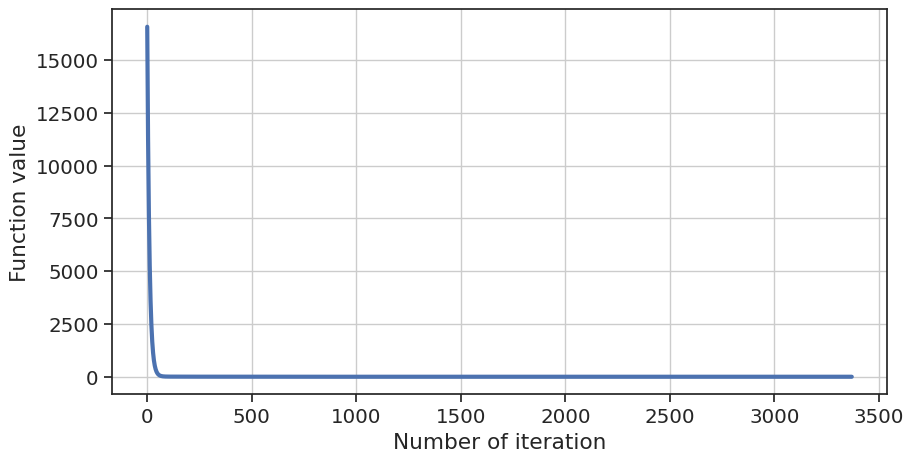

INFO: n = 10, condition number = 1
INFO: GD converge at 289 iteration, min f(x) = -43.90564720910747


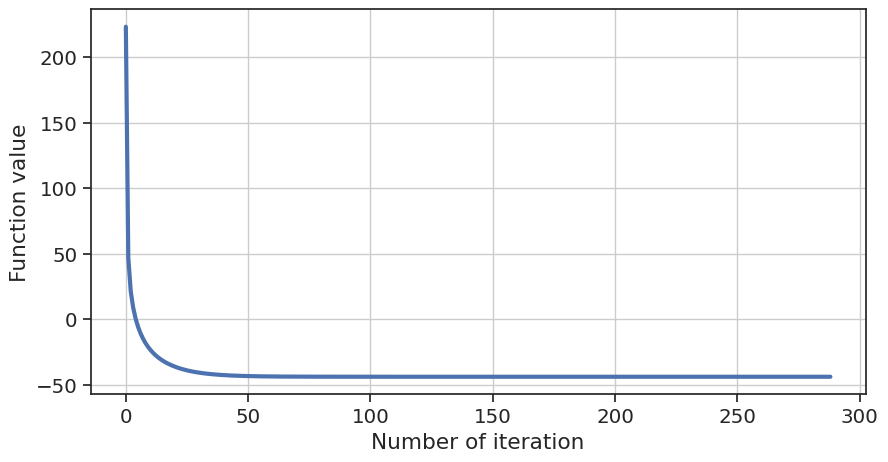

INFO: n = 10, condition number = 100
INFO: GD converge at 536 iteration, min f(x) = -4.854774820913146


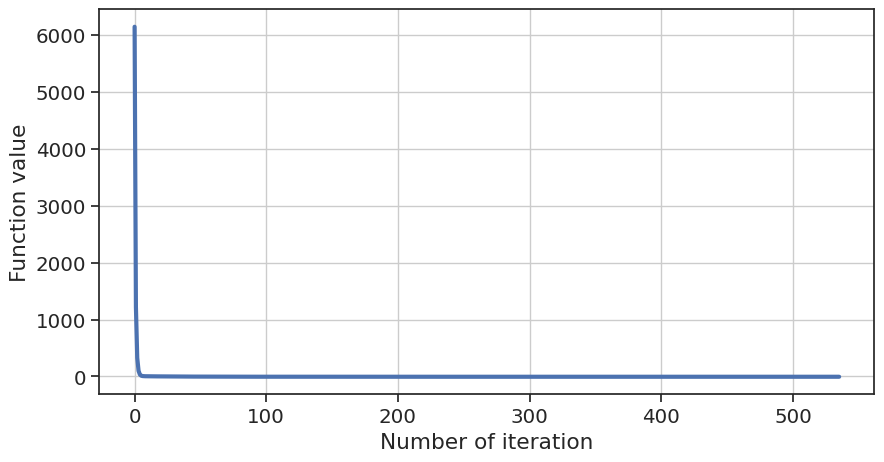

INFO: n = 10, condition number = 1000
INFO: GD converge at 4048 iteration, min f(x) = -11.137582483620557


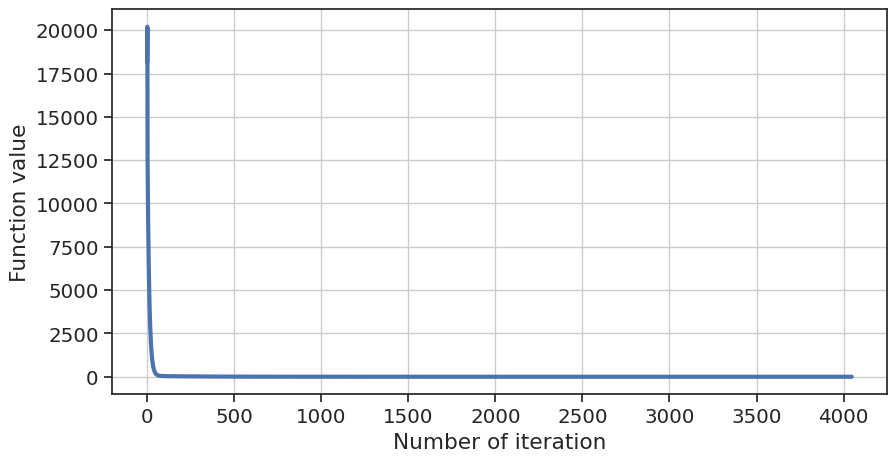

INFO: n = 1000, condition number = 1
INFO: GD converge at 5076 iteration, min f(x) = -2915.945619750493


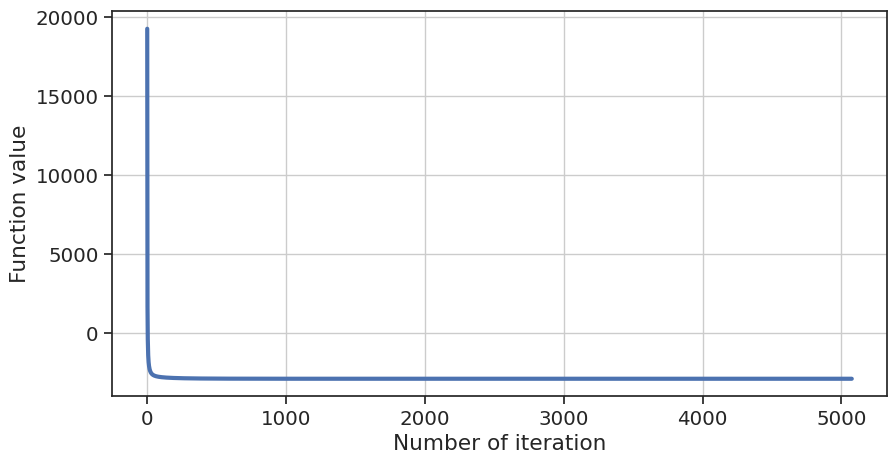

INFO: n = 1000, condition number = 100
INFO: GD converge at 423 iteration, min f(x) = -170.25165817139649


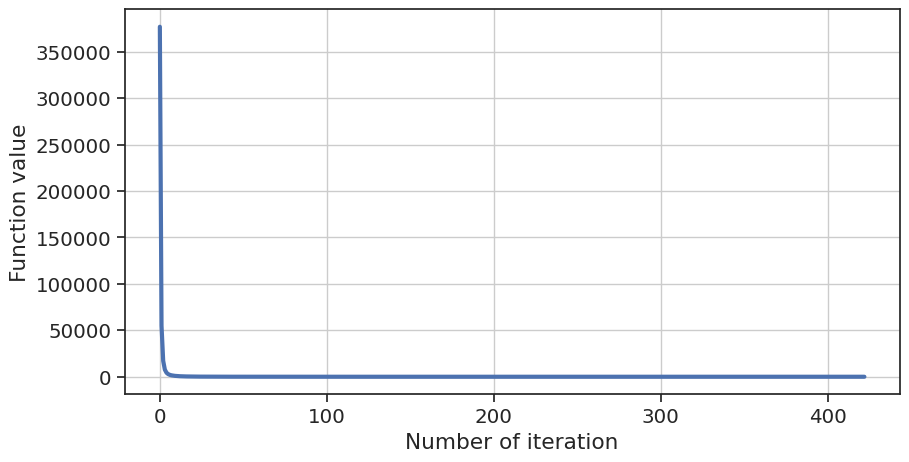

INFO: n = 1000, condition number = 1000
INFO: GD converge at 1789 iteration, min f(x) = -27.032056293945764


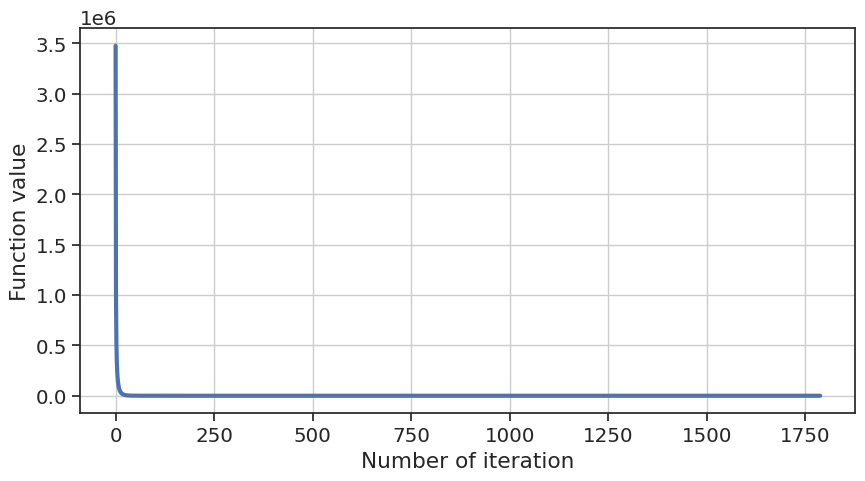

In [17]:
N = int(1e4)
eps = 1e-12


for A, b in zip(A_list, b_list):
    
    params = (A, b)
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, _ = gradient_descent(n, N, alpha, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    params, x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

**Как зависит поведение методов от числа обусловленности и от начальной точки?**

Число итераций градиентного спуска, необходимых для достижения заданной точки увеличивается с ростом числа обусловленности.

При небольших числах обусловленности градиентный спуск почти не зависит от начальной точки. 

Для числа обусловленности 1000 градиентный спуск, запущенный при разных начальных точках может давать разные результаты. Чтобы этого избежать, нужно повысить требуемую точность (т. е. уменьшить значение `eps`)


Чем меньше значение точности `eps`, тем больше итераций требуется для ее достижения, но ответ получается точнее.

## Task 3: Rosenbrock function

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

$$ x^0 = (1.2, ~ 1.2), ~ x^0 = (-1.2, ~ 1) $$

1. Аналитически найдите точку минимума.
2. Исследуйте зависимость сходимости градиентного спуска от начального приближения, шаг метода выбирать по правилу Армихо. Необходимо рассмотреть как минимум 2 разные начальные точки $x_0$ и и 3 разные точности $\varepsilon$.
3. Постройте график зависимости длины шага от итерации для каждой начальной точки. Какой вывод Вы можете сделать?



---

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

Найдем точку минимума:
$$ \frac{\partial f}{\partial x_1} = - 400 x_1 (x_2 - x_1^2) + 2(x_1 - 1)  = 0 \quad \quad (1)
$$
$$ \frac{\partial f}{\partial x_2} = 200 (x_2 - x_1^2) = 0 \quad \quad (2) $$

$$ (2) \Rightarrow (x_2 - x_1^2) = 0 \rightarrow (1) \rightarrow x_1 - 1 = 0$$

$$x_1 = 1 \rightarrow (1) \Rightarrow x_2 = 1$$

**Минимум функции**:
$$ (x_1^*, x_2^*) = (1, 1); \quad f(x_1^*, x_2^*) = 0 $$


---

In [19]:
def f_Rosenbrock(x: np.ndarray) -> float:
    """Rosenbrock function"""
    x1, x2 = x
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

def grad_f_Rosenbrock(x: np.ndarray) -> np.ndarray:
    """Gradient of Rosenbrock function f(x1, x2)"""
    x1, x2 = x
    grad_x = -400 * x1 * (x2 - x1**2) + 2 * (x1 - 1)
    grad_y = 200 * (x2 - x1**2)
    
    return np.array([grad_x, grad_y])

1) Начальная точка $ x^0 = (1.2, ~ 1.2)$

In [20]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, 
                                                    f_Rosenbrock, grad_f_Rosenbrock,
                                                    x0=x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.900000 to 0.450000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.450000 to 0.225000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.225000 to 0.112500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.112500 to 0.056250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.056250 to 0.028125
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.028125 to 0.014063
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.014063 to 0.007031
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.007031 to 0.003516
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.003516 to 0.001758
INFO: GD converge at 2065 iteration, min f(x) = 0.0002004877501869588
DEBUG: x_min = [1.01414824 1.02855278]


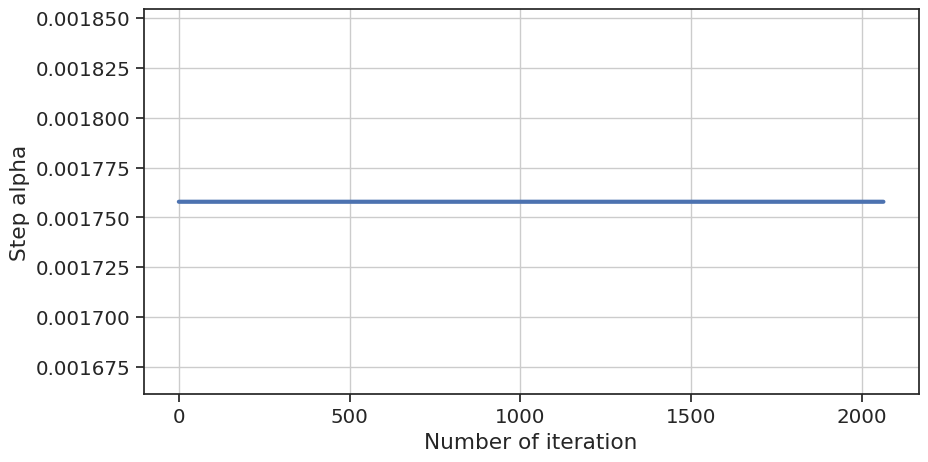

In [21]:
draw_alpha_plot(alphas, N_iterations)

2) Начальная точка $ x^0 = (-1.2, ~ 1)$

In [22]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([-1.2, 1])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, 
                                                    f_Rosenbrock, grad_f_Rosenbrock,
                                                    x0=x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.900000 to 0.450000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.450000 to 0.225000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.225000 to 0.112500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.112500 to 0.056250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.056250 to 0.028125
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.028125 to 0.014063
DEBUG: iteration: 1; Armijo condition is not true, change alpha from 0.014063 to 0.007031
DEBUG: iteration: 1; Armijo condition is not true, change alpha from 0.007031 to 0.003516
DEBUG: iteration: 2; Armijo condition is not true, change alpha from 0.003516 to 0.001758
DEBUG: iteration: 2; Armijo condition is not true, change alpha from 0.001758 to 0.000879
INFO: GD converge at 9145 iteration, min f(x) = 0.0006513648687563363
DEBUG: x_min = [0.97449919 0.9

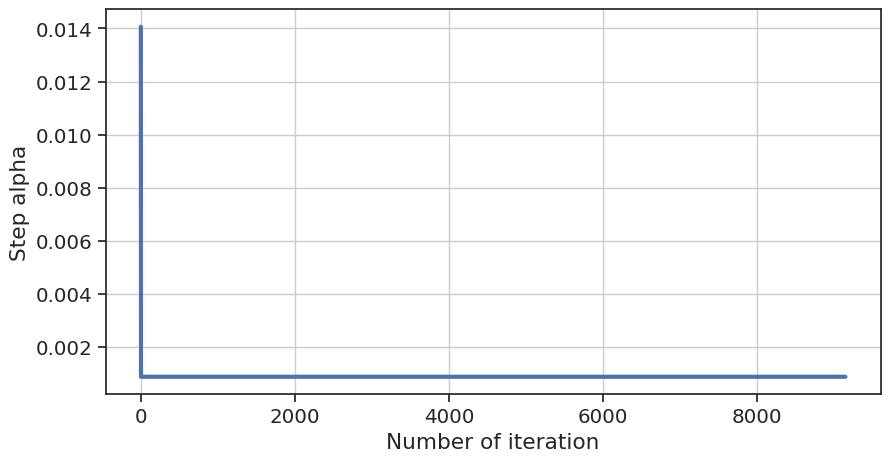

In [23]:
draw_alpha_plot(alphas, N_iterations)

**Вывод:** 

Видим, что в данном случае число итераций необходимых для сходимости может вырасти в 3 раза при неудачном начальном приближении.

Правило Армихо корректирует длину шага `alpha` на первых итерациях, после чего она не меняется до конца обучения.
Это помогает методу не разойтись в случае когда мы задали слишком большое `alpha`, но в то же время такое сильное уменьшение шага приводит к увеличению числа итераций, необходимых для достижения заданной точности.

3) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-5}$

In [24]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-5
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, 
                                                    f_Rosenbrock, grad_f_Rosenbrock,
                                                    x0=x0, verbose=False)

INFO: GD converge at 79 iteration, min f(x) = 0.0029325730519402147


4) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-8}$

In [25]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, 
                                                    f_Rosenbrock, grad_f_Rosenbrock,
                                                    x0=x0, verbose=False)

INFO: GD converge at 2065 iteration, min f(x) = 0.0002004877501869588


5) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-12}$

In [26]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-12
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, 
                                                    f_Rosenbrock, grad_f_Rosenbrock,
                                                    x0=x0, verbose=False)

INFO: GD converge at 8671 iteration, min f(x) = 1.959678667215104e-08


При увеличнии точности (понижении `eps`), число итераций растет, но ответ становится все ближе к аналитическому

## Task 4.2: Conjugate gradient method

Для функции:

$$ f(x) = x_1^2 + x_2^2 + x_3^2 - x_1 x_2 - x_1 x_3 + x_2 x_3 + x_1 + x_2,$$
$$ x_0 = (0, 0, 1)^T $$

делайте три шага методом сопряженных градиентов. Проверьте, что для выпуклой квадратичной функции МСГ сходится не более чем за $n$ шагов, где $n$ – размерность пространства.

Перепишем функцию $f(x)$ в виде:


$$ f(x) = \frac{1}{2} x^T A x + b^T x,  $$

$$ \text{где } A = \left( \begin{matrix}
    2 & -1 & -1 \\ 
    -1 & 2 & 1 \\
    -1 & 1 & 2
  \end{matrix} \right), \quad b = (1, 1, 0)^T, \quad x = (x_1, x_2, x_3)^T
 $$


### Conjugate gradient method

In [27]:
def conjugate_gradient_method(x0: np.ndarray, A: np.ndarray, b: np.ndarray, 
                              eps: float, verbose: bool = False) -> Tuple[float, np.ndarray, int]:
    """
    Conjugate gradient method for quadratic functions 
        f(x) = (1/2) * (x.T * A * x) + (b.T * x) + c
    
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param x0: initial guess of x
    :return: f_min, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
        
    h_k = grad_f_quadratic(x0, A, b)
    h_k1 = grad_f_quadratic(x0, A, b)
    x_k = x0
    x_k1 = x0
    n = len(b)
    n_steps = n
    
    norm_0 = np.linalg.norm(grad_f_quadratic(x0, A, b))
    end_iteration = n

    for k in range(n_steps):
        logger.debug(f'Step: k = {k}')
        
        x_k = x_k1
        h_k = h_k1
        
        # compute alpha
        alpha_k = - (grad_f_quadratic(x_k, A, b) @ h_k) / (h_k @ A @ h_k)
        logger.debug(f'Alpha_k = {alpha_k}')

        # perform step
        x_k1 = x_k + alpha_k * h_k
        logger.debug(f'X_k = {x_k}')
        logger.debug(f'X_k+1 = {x_k1}')

        # compute beta
        beta = (grad_f_quadratic(x_k1, A, b) @ A @ h_k) / (h_k @ A @ h_k)
        logger.debug(f'Beta_k = {beta}')

        # find next conjugated vector
        h_k1 = grad_f_quadratic(x_k1, A, b) - (beta * h_k)
        logger.debug(f'h_k = {h_k}')
        logger.debug(f'h_k+1 = {h_k1} \n')
        
        # check that h_k and h_k+1 are A-conjugated
        assert np.isclose(h_k1 @ (A @ h_k), 0, rtol=0, atol=1e-10), f"h_k and h_k+1 are not A-conjugated, {h_k1 @ A @ h_k}"


        # check stop criteria
        norm_k = np.linalg.norm(grad_f_quadratic(x_k1, A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps

        if stop_criteria:
            f_min = f_quadratic(x_k1, A, b)
            x_min = x_k1
            end_iteration = k+1
            logger.info(f'CG converge at {k+1} iteration, min f(x) = {f_min}')
            logger.debug(f'x_min = {x_min}')
            break
        
    if not stop_criteria:
        f_min = f(x_k1, A, b)
        x_min = x_k1
        logger.info(f'(!) CG didnt converge')
        logger.debug(f'last f(x) = {f(x_k1, A, b)} at x = {x_k1}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
    
    
    return f_min, x_min, end_iteration

In [28]:
# условия задачи

A = np.array([[2, -1, -1],
              [-1, 2, 1],
              [-1, 1, 2]])

x0 = np.array([0, 0, 1])

b = np.array([1, 1, 0])

n = 3

In [29]:
eps = 1e-15

f_min, x_min, end_iteration = conjugate_gradient_method(x0, A, b, eps, verbose=True)

DEBUG: Step: k = 0
DEBUG: Alpha_k = -0.3333333333333333
DEBUG: X_k = [0 0 1]
DEBUG: X_k+1 = [ 0.         -0.66666667  0.33333333]
DEBUG: Beta_k = -0.22222222222222218
DEBUG: h_k = [0 2 2]
DEBUG: h_k+1 = [1.33333333 0.44444444 0.44444444] 

DEBUG: Step: k = 1
DEBUG: Alpha_k = -0.7500000000000001
DEBUG: X_k = [ 0.         -0.66666667  0.33333333]
DEBUG: X_k+1 = [-1.00000000e+00 -1.00000000e+00 -5.55111512e-17]
DEBUG: Beta_k = -5.200010849845538e-33
DEBUG: h_k = [1.33333333 0.44444444 0.44444444]
DEBUG: h_k+1 = [ 6.93334780e-33  2.31111593e-33 -1.11022302e-16] 

INFO: CG converge at 2 iteration, min f(x) = -1.0
DEBUG: x_min = [-1.00000000e+00 -1.00000000e+00 -5.55111512e-17]


Сравним с методом сопряженных градиентов из scipy

In [30]:
scipy.optimize.minimize(f_quadratic, x0=x0, args=(A, b), method='CG')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.9999999999999996
       x: [-1.000e+00 -1.000e+00 -7.506e-09]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 32
    njev: 8

Проверим, что для выпуклой квадратичной функции МСГ сходится не более чем за $n$ шагов, где $n$ – размерность пространства.

In [35]:
n = 10
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

print(f"Размерность пространства = {len(b)}")

Размерность пространства = 10


In [36]:
eps = 1e-15
x0 = sps.uniform(loc=5, scale=100).rvs(size=n)

f_min, x_min, end_iteration = conjugate_gradient_method(x0, A, b, eps, verbose=False)

INFO: CG converge at 9 iteration, min f(x) = -2.172278326742451


Видим, что для произвольной квадратичной функции с размерностью пространства 10, МСГ сошелся за 10 шагов

## Task 5: Nesterov, Heavy-Ball

### Heavy-Ball method

$$ x_{k+1} = x_k - \alpha  \nabla f (x_k) + \beta (x_k - x_{k-1}) $$

$$ \alpha, ~ \beta - \text{параметры} $$

In [37]:
def heavy_ball_method(N: int, eps: float,
                      alpha: float, beta: float, 
                      f: Callable, grad_f: Callable,
                      x0: np.ndarray,
                      params: Tuple[Any, ...] = (),
                      verbose: bool = False):   
    """Heavy-Ball method

    :param N: max number of iterations
    :param eps: tolerance
    :param alpha, beta: method parameters
    :param f: objective function
    :param grad_f: gradient of objective function
    :param x0: initial guess of x
    :param params: objective function arguments
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    n = len(x0)
    x = np.zeros((N, n))
    f_vals = np.zeros(N)
    x[0] = x0
    x[1] = x0
    f_vals[0] = f(x[0], *params)

    norm_0 = np.linalg.norm(grad_f(x[0], *params))
    end_iteration = N

    for k in range(1, N-1):
        
        x[k+1] = x[k] - alpha * grad_f(x[k], *params) + beta * (x[k] - x[k-1])
        
        norm_k = np.linalg.norm(grad_f(x[k+1], *params))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        f_vals[k] = f(x[k], *params)
        f_vals[k+1] = f(x[k+1], *params)
        
        if stop_criteria:
            x_min = x[k+1]
            end_iteration = k+1
            logger.info(f'HB converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x_min}')
            break
    
    if not stop_criteria:
            x_min = None
            logger.info(f'(!) HB didnt converge, may be need to increase number of iterations N')
            logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
            logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
            
    return f_vals, x_min, end_iteration

#### Сравнение с градиентным спуском

In [46]:
n = 2
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

In [47]:
N = int(1e4)
alpha = 0.001
beta = 0.3
eps = 1e-10

x0 = sps.uniform(loc=1, scale=10).rvs(n)
x0

array([10.96917025,  2.74967636])

Сравнение

In [48]:
f_vals_HB, x_min, N_iter_HB = heavy_ball_method(N, eps, alpha, beta, 
                                                f_quadratic, grad_f_quadratic,
                                                x0=x0, params=(A, b), 
                                                verbose=False)

INFO: HB converge at 5999 iteration, min f(x) = -6.412187777748439


In [49]:
f_vals_GD, x, N_iter_GD, alphas = gradient_descent(n, N, alpha, eps, 
                                                   f_quadratic, grad_f_quadratic,
                                                   params=(A, b), x0=x0, verbose=False)

INFO: GD converge at 8575 iteration, min f(x) = -6.412187777670539


In [50]:
scipy.optimize.minimize(f_quadratic, x0, args=(A, b))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -6.4121884277178145
        x: [-4.271e-01 -3.317e+00]
      nit: 4
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.000e-01  6.636e-07]
            [ 6.636e-07  1.000e+00]]
     nfev: 18
     njev: 6

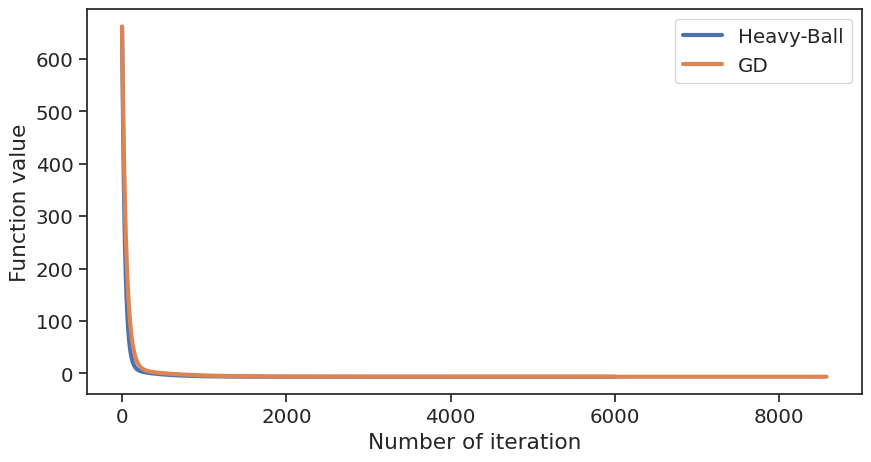

In [51]:
draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

Те же графики в лог-лог шкале

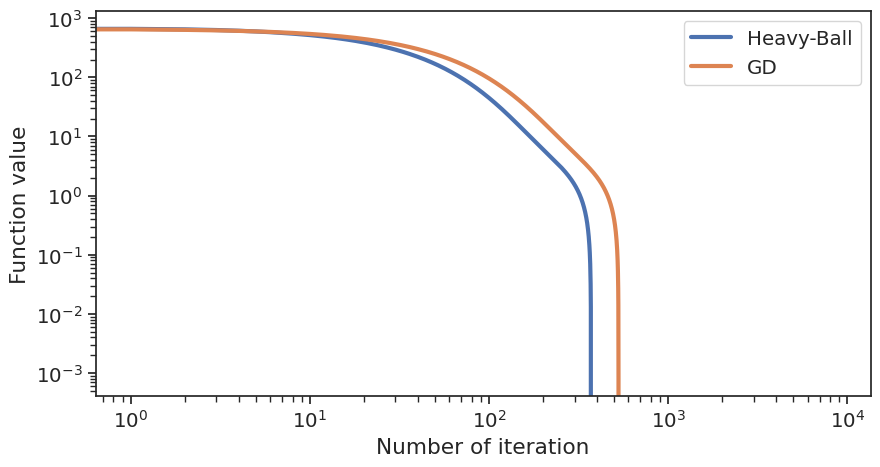

In [52]:
draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

plt.yscale('log')
plt.xscale('log')

Оба метода сходятся примерно за одинаковое количество итераций, при этом Heavy-Ball может вести себя немонотонно

### Nesterov momentum


$$ x_{k+1} = x_k + \beta_k (x_k - x_{k-1}) - \alpha_k \nabla f (x_k + \beta_k (x_k - x_{k-1})) $$

$$ \alpha_k, ~ \beta_k - \text{параметры} $$

In [53]:
def Nesterov_momentum(N: int, eps: float,
                      f: Callable, grad_f: Callable,
                      x0: np.ndarray, 
                      y0: Optional[np.ndarray] = None,
                      params: Tuple[Any, ...] = (),
                      verbose: bool = False):
    """Nesterov method

    :param N: max number of iterations
    :param eps: tolerance
    :param f: objective function
    :param grad_f: gradient of objective function
    :param x0: initial guess of x
    :param y0: initial guess of x
    :param params: objective function arguments
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    eigen_vals = np.linalg.eigvals(A)
    mu = np.min(eigen_vals)  # константа сильной выпуклости
    L = np.max(eigen_vals)  # константа Липшица
    
    n = len(x0)
    x = np.zeros((N, n))
    y = np.zeros((N, n))
    x[0] = x0
    if y0 is None: y[0] = x0

    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], *params)

    norm_0 = np.linalg.norm(grad_f(x[0], *params))
    end_iteration = N

    for k in range(N-1):
        # compute method params
        alpha_k = 1 / L
        beta_k = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
        # beta_k = k / (k + 3)
        
        # method step
        x[k+1] = y[k] - alpha_k * grad_f(y[k], *params)
        y[k+1] = x[k+1] + beta_k * (x[k+1] - x[k])
        
        norm_k = np.linalg.norm(grad_f(x[k+1], *params))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        f_vals[k] = f(x[k], *params)
        f_vals[k+1] = f(x[k+1], *params)
        
        if stop_criteria:
            x_min = x[k+1]
            end_iteration = k+1
            logger.info(f'Nesterov converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x_min}')
            break
        
    if not stop_criteria:
            x_min = None
            logger.info(f'(!) Nesterov didnt converge, may be need to increase number of iterations N')
            logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
            logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
    
    return f_vals, x_min, end_iteration

#### Сравнение с градиентным спуском

In [54]:
n = 2
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

In [55]:
N = int(1e4)
eps = 1e-8

x0 = sps.uniform(loc=1, scale=10).rvs(n)
x0

array([2.45218112, 2.90905665])

Сравнение

In [56]:
f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    x0=x0, params=(A, b),
                                                    verbose=False)

INFO: Nesterov converge at 24 iteration, min f(x) = -0.6860064504393159


In [57]:
f_vals_GD, x, N_iter_GD, alphas = gradient_descent(n, N, alpha, eps, 
                                                   f_quadratic, grad_f_quadratic,
                                                   params=(A, b), x0=x0, verbose=False)

INFO: GD converge at 6878 iteration, min f(x) = -0.686005585037162


In [58]:
scipy.optimize.minimize(f_quadratic, x0, args=(A, b))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.6860107779111139
        x: [-6.868e-01 -3.001e-01]
      nit: 4
      jac: [-1.170e-06  1.267e-06]
 hess_inv: [[ 1.007e+00 -7.271e-04]
            [-7.271e-04  1.001e-01]]
     nfev: 15
     njev: 5

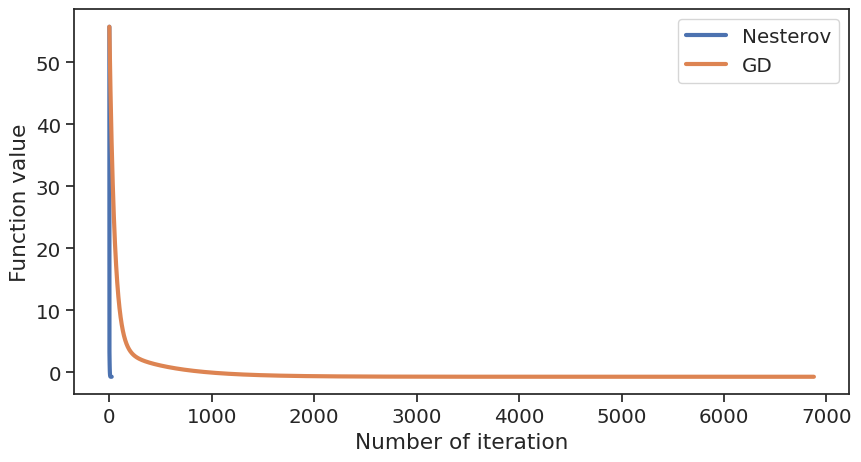

In [59]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

В лог-лог шкале

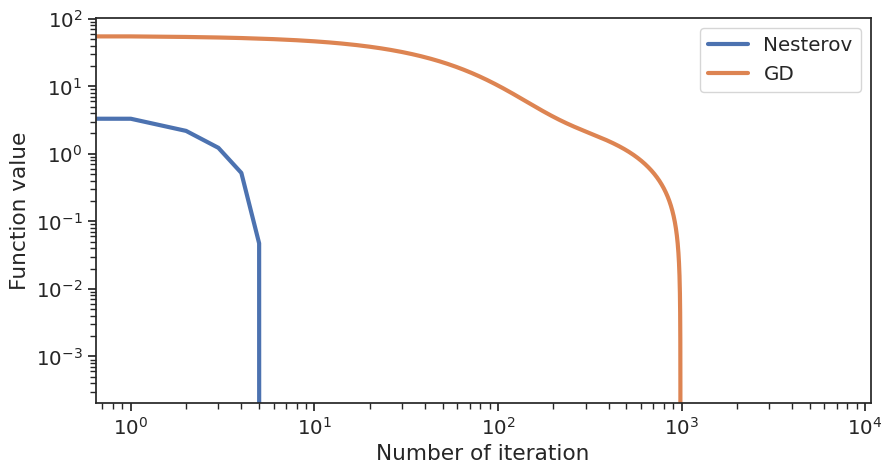

In [60]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

plt.yscale('log')
plt.xscale('log')

Метод Нестерова сходится в среднем в 2-10 раз быстрее чем градиентный спуск

### Генерация 9 матриц с разными числами обусловленности

In [61]:
n_list = [2, 10, 1000]
cond_num_list = [1, 100, 1000]

A_list = []
b_list = []

for n in n_list:
    for cond_num in cond_num_list:        
        A, b = quadratic_func_params(n, cond_num)
        A_list.append(A)
        b_list.append(b)

#### Разные начальные точки

Начальная точка 1

INFO: n = 2, condition number = 1
INFO: HB converge at 8050 iteration, min f(x) = -20.194948393771643
INFO: Nesterov converge at 1 iteration, min f(x) = -20.194948401620056


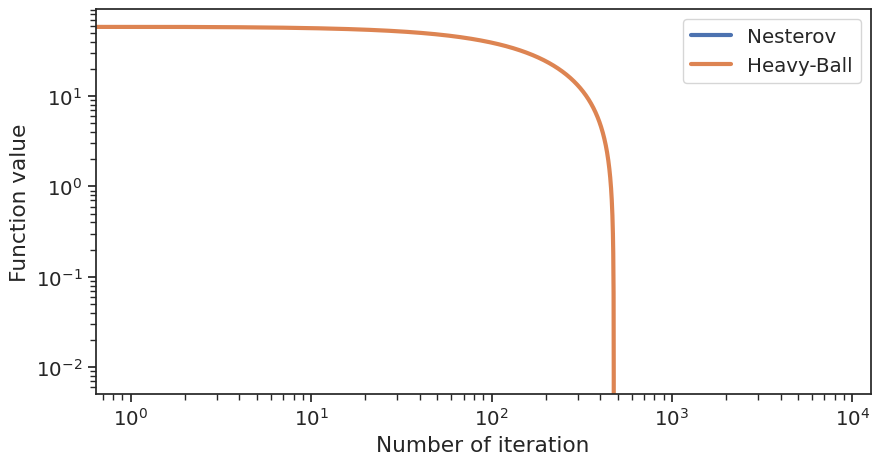

INFO: n = 2, condition number = 100
INFO: HB converge at 5000 iteration, min f(x) = -10.269490235000744
INFO: Nesterov converge at 90 iteration, min f(x) = -10.26949119775768


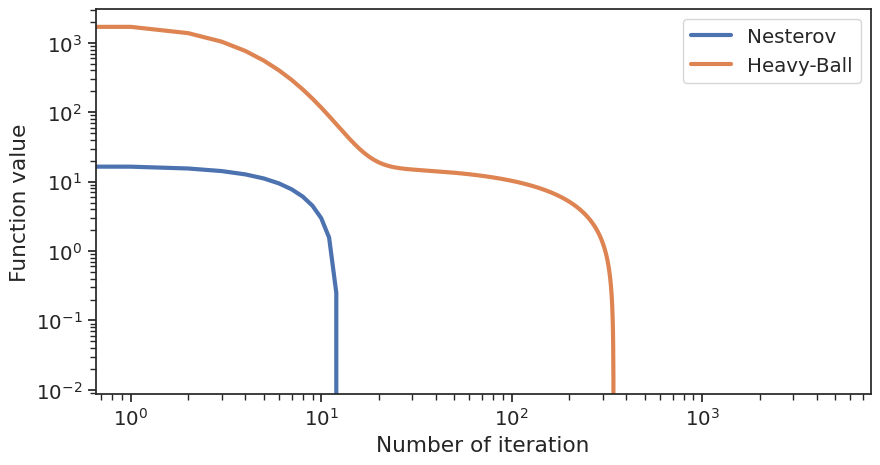

INFO: n = 2, condition number = 1000
INFO: HB converge at 2924 iteration, min f(x) = -0.4042441435602073
INFO: Nesterov converge at 191 iteration, min f(x) = -0.4042614780036255


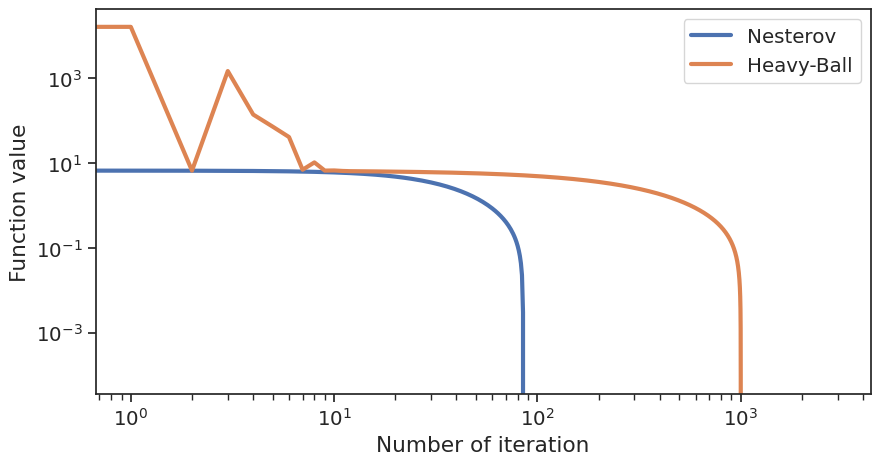

INFO: n = 10, condition number = 1
INFO: HB converge at 7457 iteration, min f(x) = -34.1504573562457
INFO: Nesterov converge at 10 iteration, min f(x) = -34.15045738136551


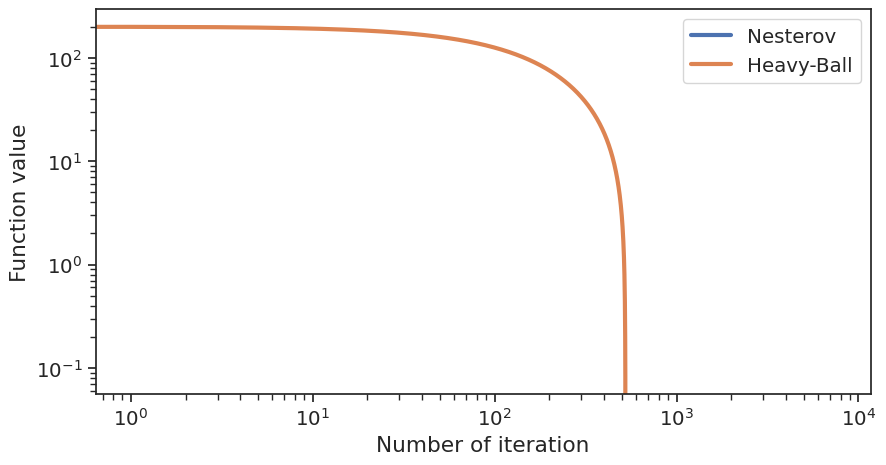

INFO: n = 10, condition number = 100
INFO: HB converge at 4602 iteration, min f(x) = -10.457725478689166
INFO: Nesterov converge at 84 iteration, min f(x) = -10.457727537416085


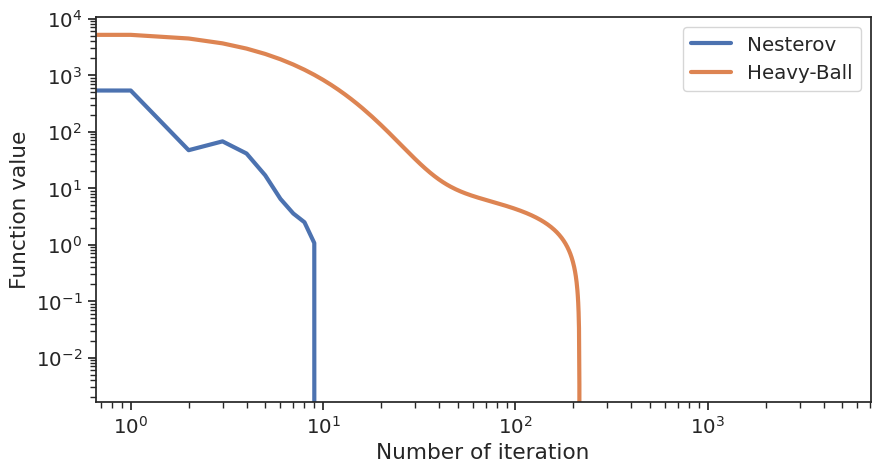

INFO: n = 10, condition number = 1000
INFO: HB converge at 3315 iteration, min f(x) = -11.451784013712984
INFO: Nesterov converge at 211 iteration, min f(x) = -11.451792453416344


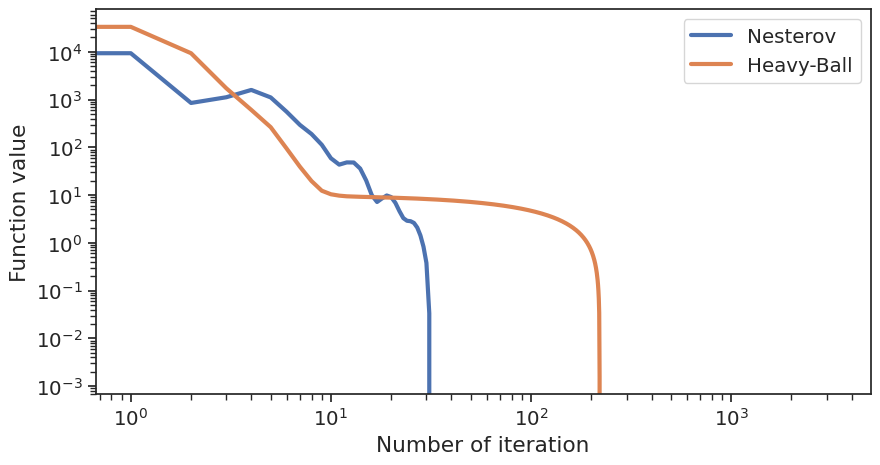

INFO: n = 1000, condition number = 1
INFO: HB converge at 6889 iteration, min f(x) = -2961.9422964672385
INFO: Nesterov converge at 10 iteration, min f(x) = -2961.9422990601297


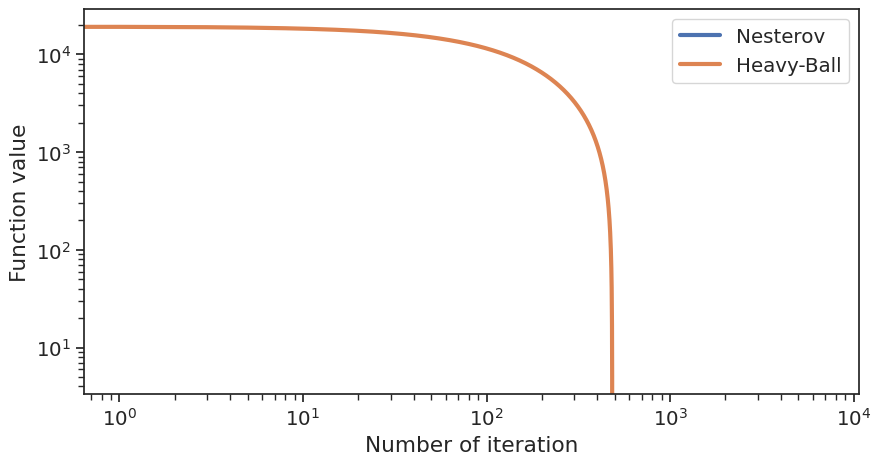

INFO: n = 1000, condition number = 100
INFO: HB converge at 3139 iteration, min f(x) = -202.18947549001513
INFO: Nesterov converge at 66 iteration, min f(x) = -202.1904278670808


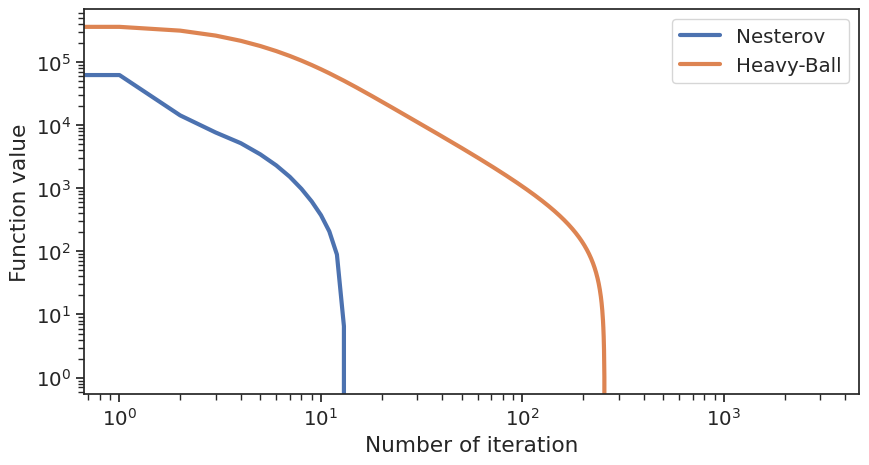

INFO: n = 1000, condition number = 1000
INFO: HB converge at 1311 iteration, min f(x) = -31.685741685767198
INFO: Nesterov converge at 147 iteration, min f(x) = -31.855055695734485


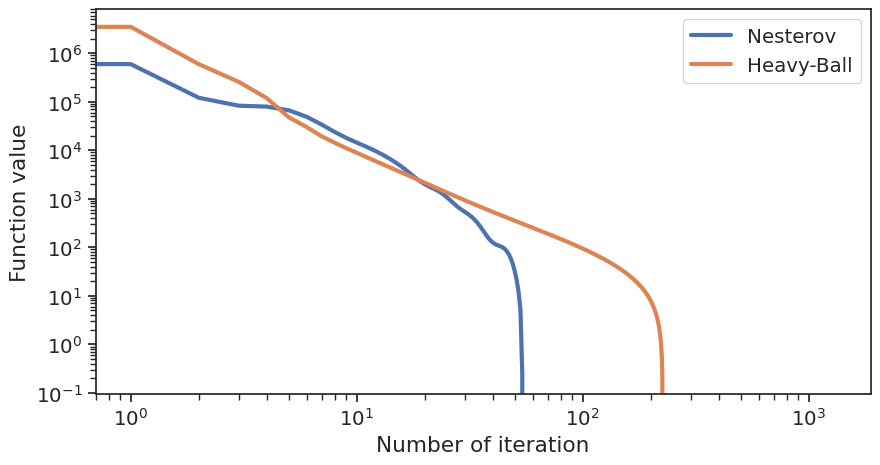

In [62]:
N = int(1e4)
eps = 1e-10

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
        
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(N, eps, alpha, beta, 
                                                   f_quadratic, grad_f_quadratic,
                                                   x0=x0, params=(A, b), 
                                                   verbose=False)
        
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                       f_quadratic, grad_f_quadratic,
                                                       x0=x0, params=(A, b),
                                                       verbose=False)
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

Начальная точка 2

INFO: n = 2, condition number = 1
INFO: HB converge at 8050 iteration, min f(x) = -20.19494776273138
INFO: Nesterov converge at 1 iteration, min f(x) = -20.194948401620056


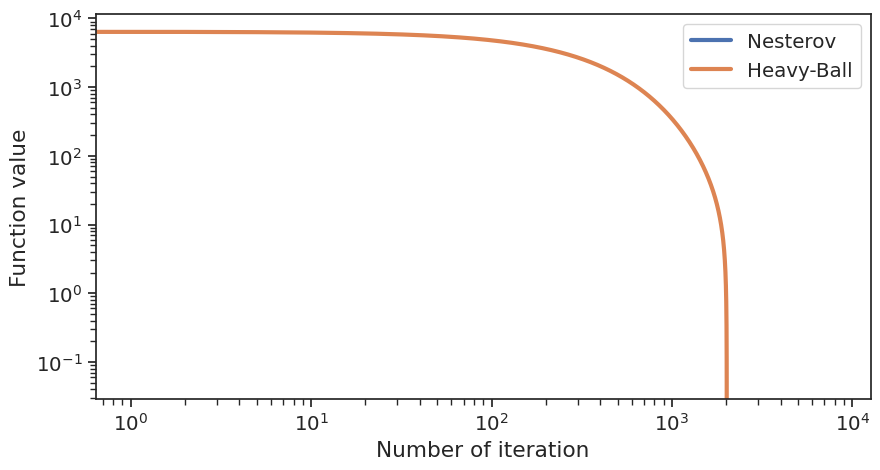

INFO: n = 2, condition number = 100
INFO: HB converge at 5357 iteration, min f(x) = -10.268389696128441
INFO: Nesterov converge at 96 iteration, min f(x) = -10.268578902638692


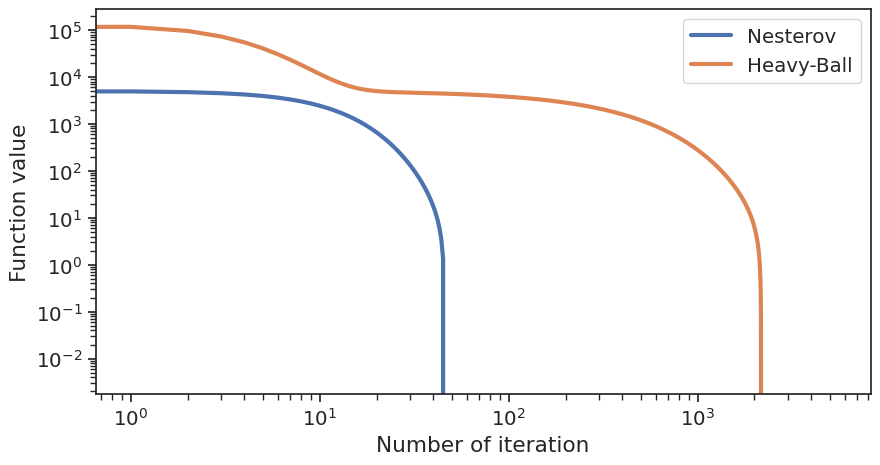

INFO: n = 2, condition number = 1000
INFO: HB converge at 3722 iteration, min f(x) = -0.2942722105334227
INFO: Nesterov converge at 232 iteration, min f(x) = -0.2969585955348654


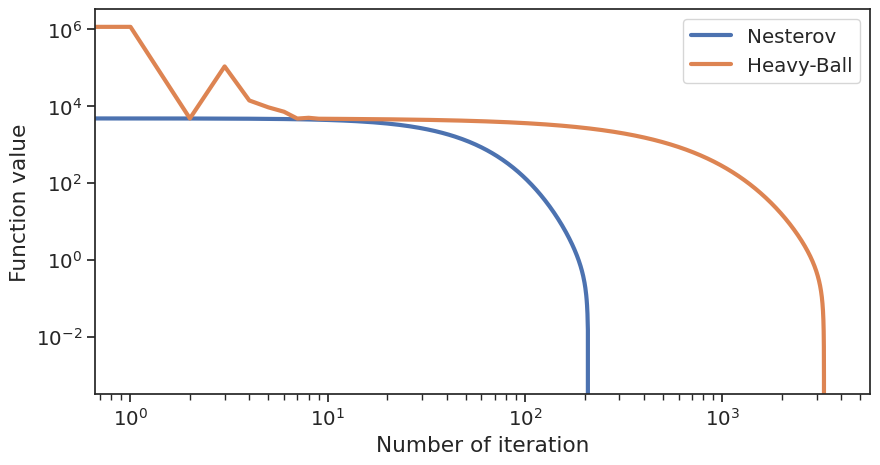

INFO: n = 10, condition number = 1
INFO: HB converge at 7277 iteration, min f(x) = -34.15045094983136
INFO: Nesterov converge at 10 iteration, min f(x) = -34.15045666692003


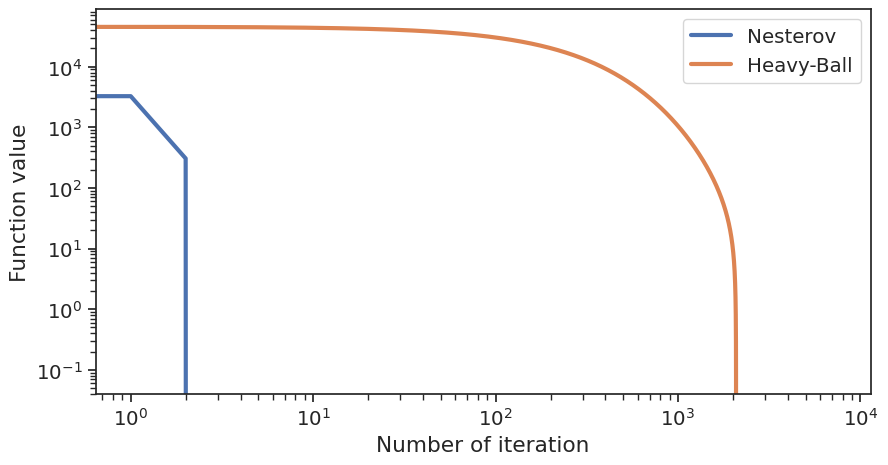

INFO: n = 10, condition number = 100
INFO: HB converge at 4464 iteration, min f(x) = -10.444602821111804
INFO: Nesterov converge at 82 iteration, min f(x) = -10.445536139289404


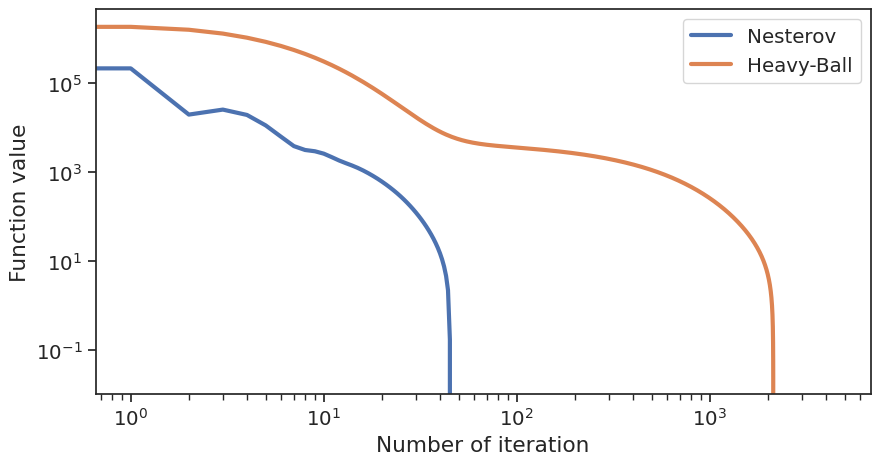

INFO: n = 10, condition number = 1000
INFO: HB converge at 3103 iteration, min f(x) = -10.905776530631059
INFO: Nesterov converge at 201 iteration, min f(x) = -10.934151425625018


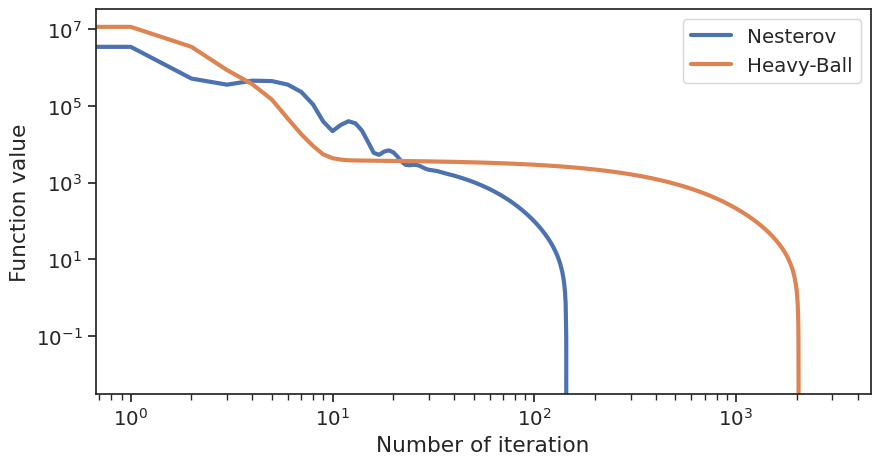

INFO: n = 1000, condition number = 1
INFO: HB converge at 6807 iteration, min f(x) = -2961.9417684403147
INFO: Nesterov converge at 10 iteration, min f(x) = -2961.942216718993


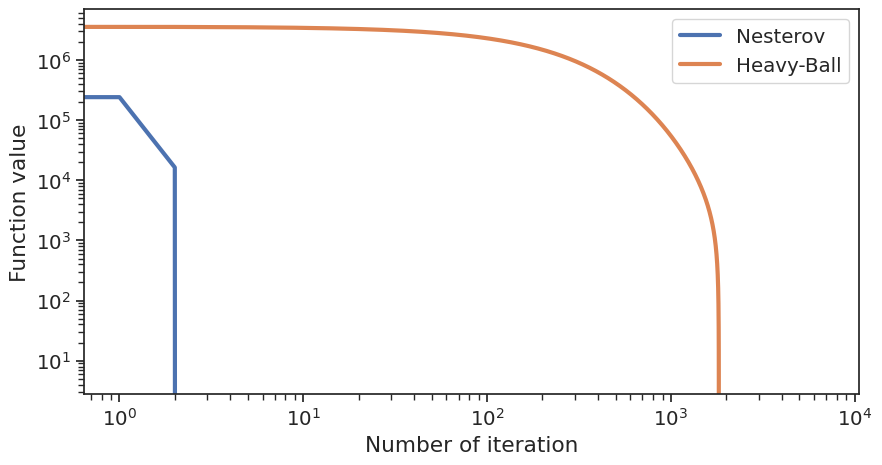

INFO: n = 1000, condition number = 100
INFO: HB converge at 3125 iteration, min f(x) = -201.4129545812603
INFO: Nesterov converge at 65 iteration, min f(x) = -201.72666009942398


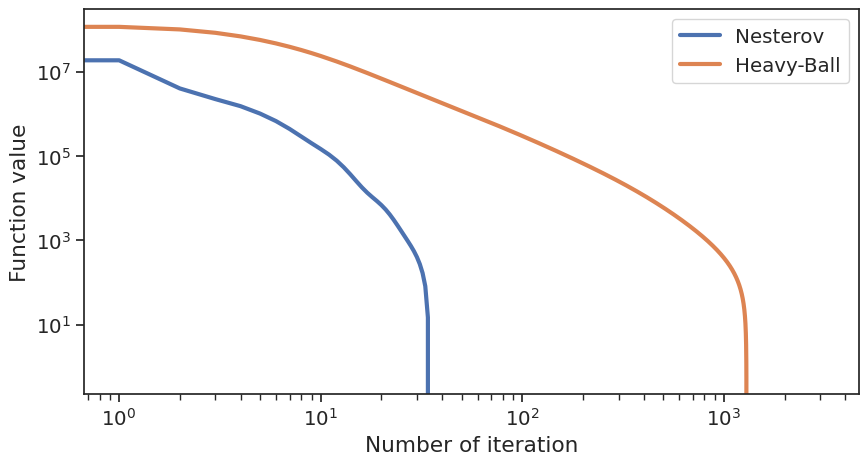

INFO: n = 1000, condition number = 1000
INFO: HB converge at 1054 iteration, min f(x) = 14.386129152619294
INFO: Nesterov converge at 147 iteration, min f(x) = -24.46235160101451


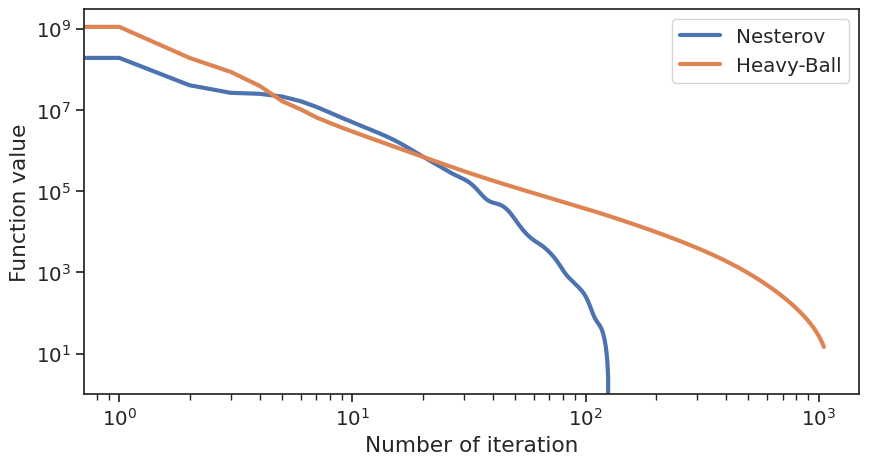

In [63]:
N = int(1e4)
eps = 1e-10

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=10, scale=100).rvs(n, random_state=32)
    
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(N, eps, alpha, beta, 
                                                   f_quadratic, grad_f_quadratic,
                                                   x0=x0, params=(A, b), 
                                                   verbose=False)
        
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                       f_quadratic, grad_f_quadratic,
                                                       x0=x0, params=(A, b),
                                                       verbose=False)
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

#### Разная точность для остановки eps

1) eps = $10^{-5}$

INFO: n = 2, condition number = 1
INFO: HB converge at 4026 iteration, min f(x) = -20.194163948473953
INFO: Nesterov converge at 1 iteration, min f(x) = -20.194948401620056


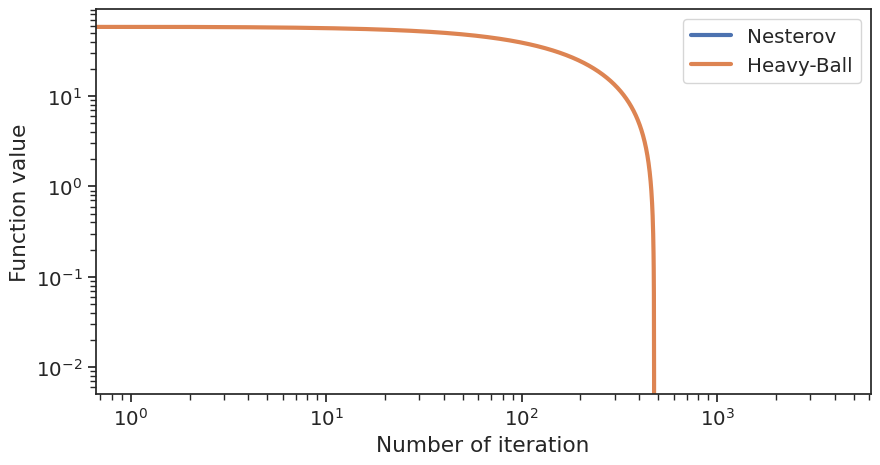

INFO: n = 2, condition number = 100
INFO: HB converge at 976 iteration, min f(x) = -8.592781872580176
INFO: Nesterov converge at 26 iteration, min f(x) = -8.795253060519101


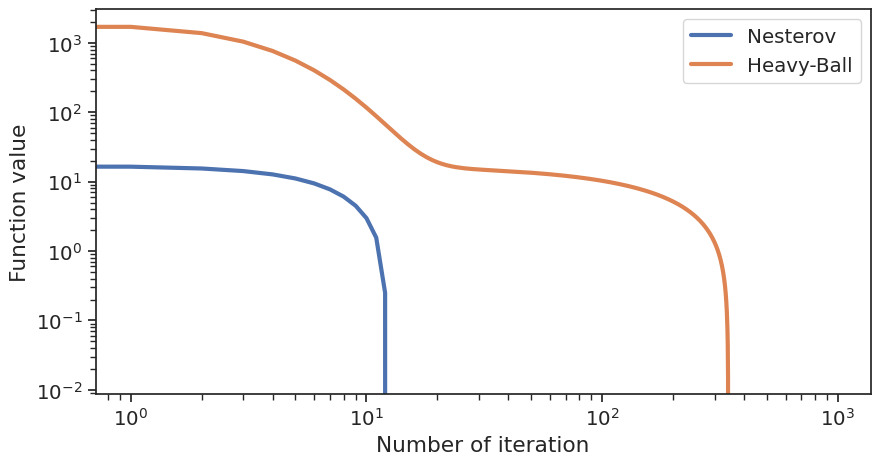

INFO: n = 2, condition number = 1000
INFO: HB converge at 2 iteration, min f(x) = 6.667109039192067
INFO: Nesterov converge at 1 iteration, min f(x) = 6.667109039192067


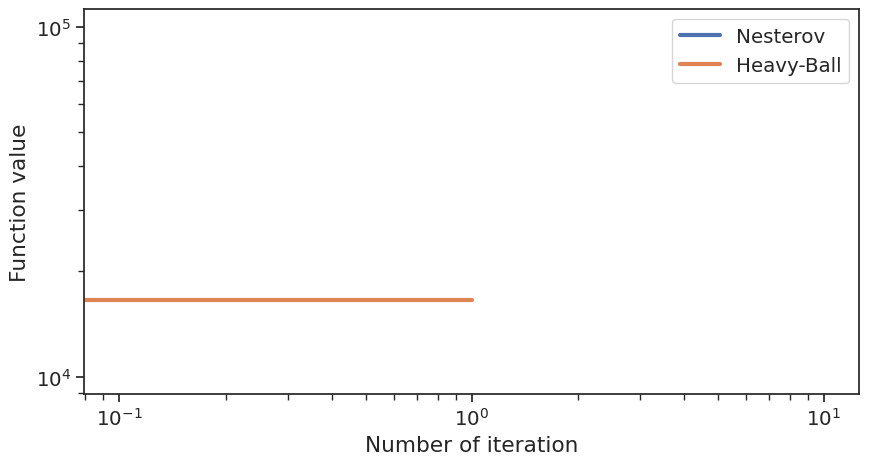

INFO: n = 10, condition number = 1
INFO: HB converge at 3539 iteration, min f(x) = -34.147401095747284
INFO: Nesterov converge at 5 iteration, min f(x) = -34.14885399807515


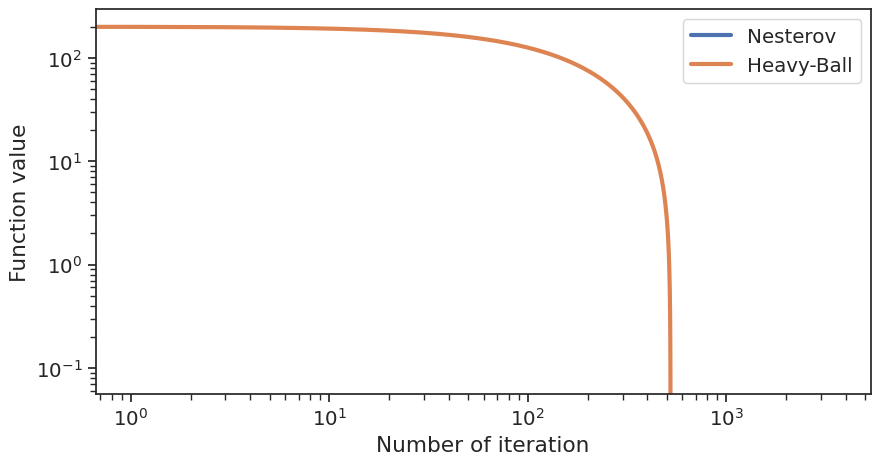

INFO: n = 10, condition number = 100
INFO: HB converge at 578 iteration, min f(x) = -6.755414792945894
INFO: Nesterov converge at 19 iteration, min f(x) = -7.489244485224759


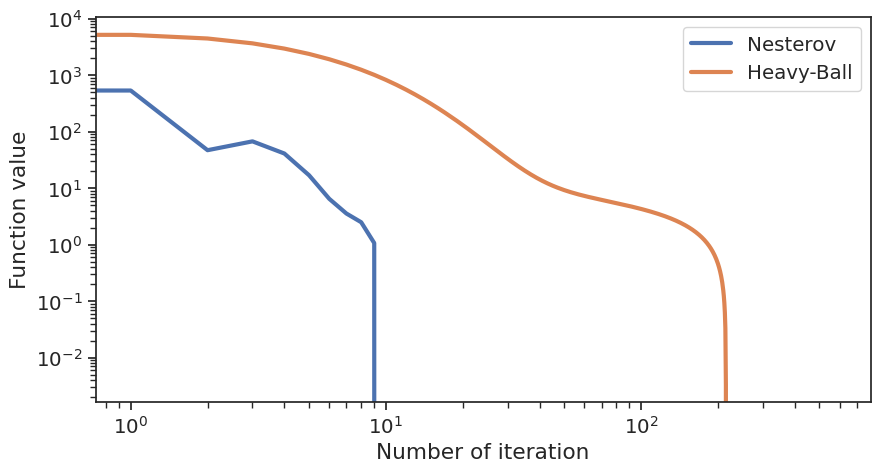

INFO: n = 10, condition number = 1000
INFO: HB converge at 11 iteration, min f(x) = 9.734064560230303
INFO: Nesterov converge at 23 iteration, min f(x) = 3.291360971611922


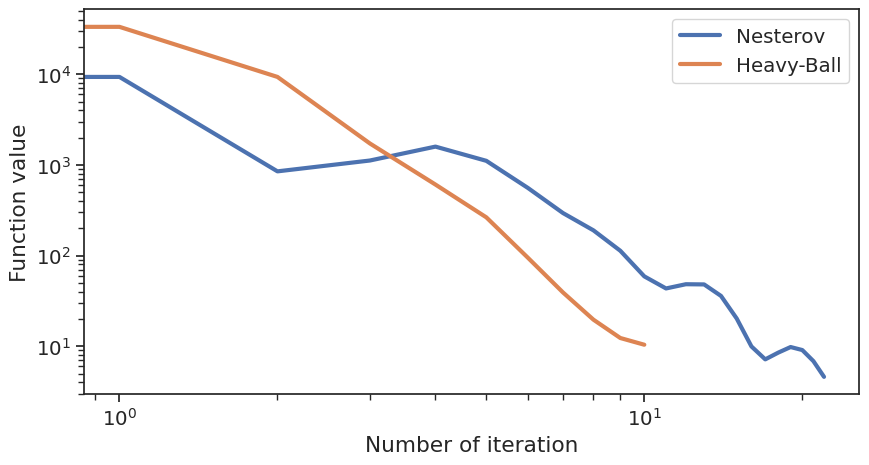

INFO: n = 1000, condition number = 1
INFO: HB converge at 3141 iteration, min f(x) = -2961.6402478699024
INFO: Nesterov converge at 5 iteration, min f(x) = -2961.834015618288


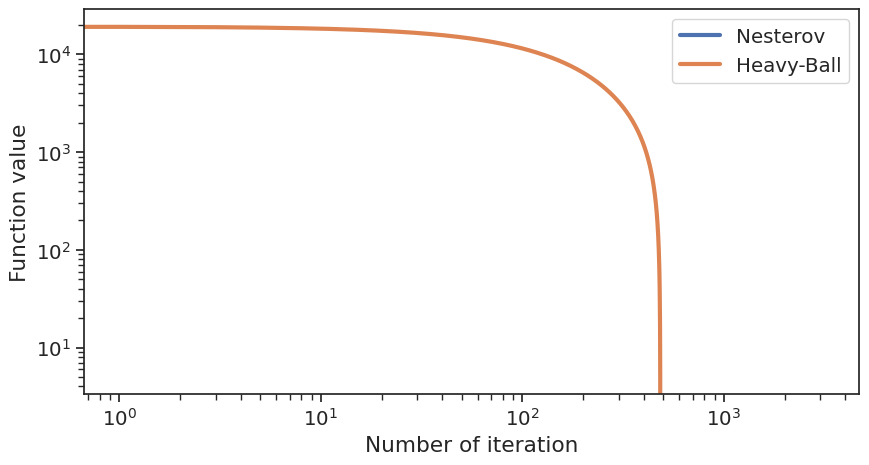

INFO: n = 1000, condition number = 100
INFO: HB converge at 349 iteration, min f(x) = -101.84651443668037
INFO: Nesterov converge at 20 iteration, min f(x) = -170.16095067973464


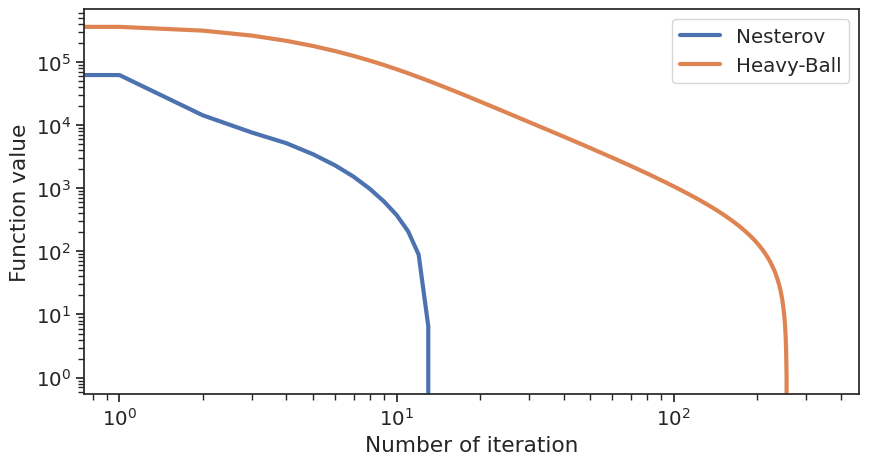

INFO: n = 1000, condition number = 1000
INFO: HB converge at 29 iteration, min f(x) = 998.311938280137
INFO: Nesterov converge at 33 iteration, min f(x) = 383.4834682373728


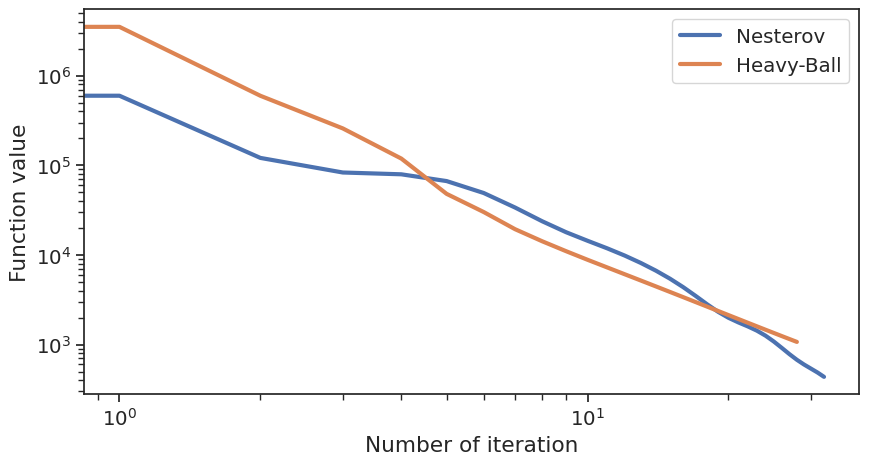

In [64]:
N = int(1e4)
eps = 1e-5

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(N, eps, alpha, beta, 
                                                   f_quadratic, grad_f_quadratic,
                                                   x0=x0, params=(A, b), 
                                                   verbose=False)
        
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                       f_quadratic, grad_f_quadratic,
                                                       x0=x0, params=(A, b),
                                                       verbose=False)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

2) eps = $10^{-8}$

INFO: n = 2, condition number = 1
INFO: HB converge at 6441 iteration, min f(x) = -20.19494761827988
INFO: Nesterov converge at 1 iteration, min f(x) = -20.194948401620056


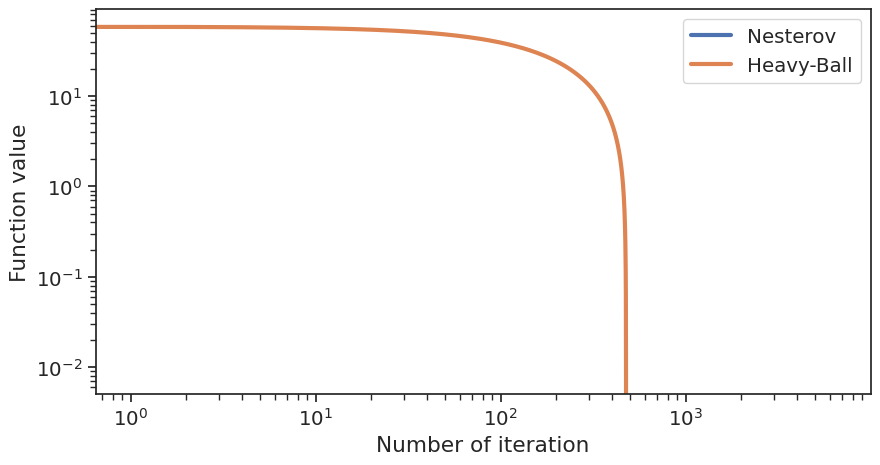

INFO: n = 2, condition number = 100
INFO: HB converge at 3390 iteration, min f(x) = -10.267827867244664
INFO: Nesterov converge at 66 iteration, min f(x) = -10.26807153685356


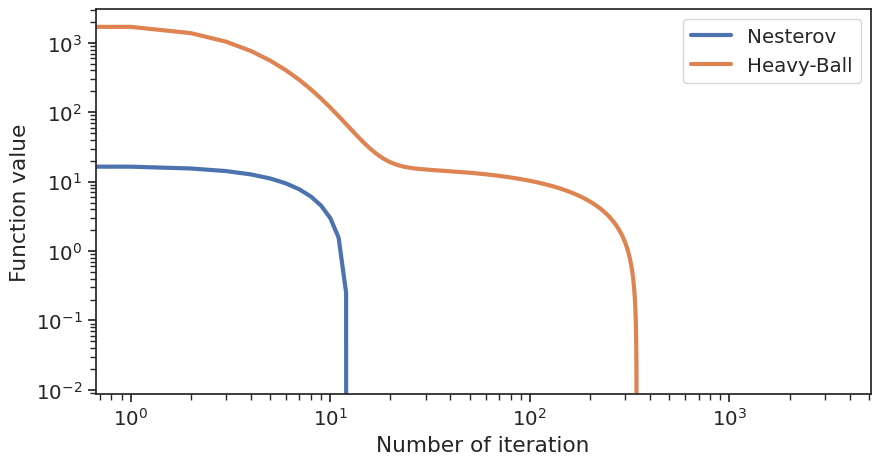

INFO: n = 2, condition number = 1000
INFO: HB converge at 1315 iteration, min f(x) = -0.24056227715262524
INFO: Nesterov converge at 104 iteration, min f(x) = -0.24281784518392294


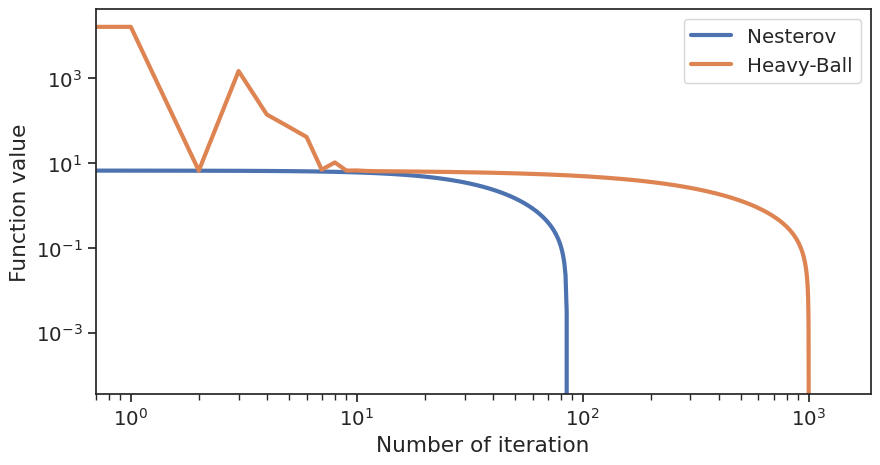

INFO: n = 10, condition number = 1
INFO: HB converge at 5879 iteration, min f(x) = -34.15045428025375
INFO: Nesterov converge at 8 iteration, min f(x) = -34.15045646239576


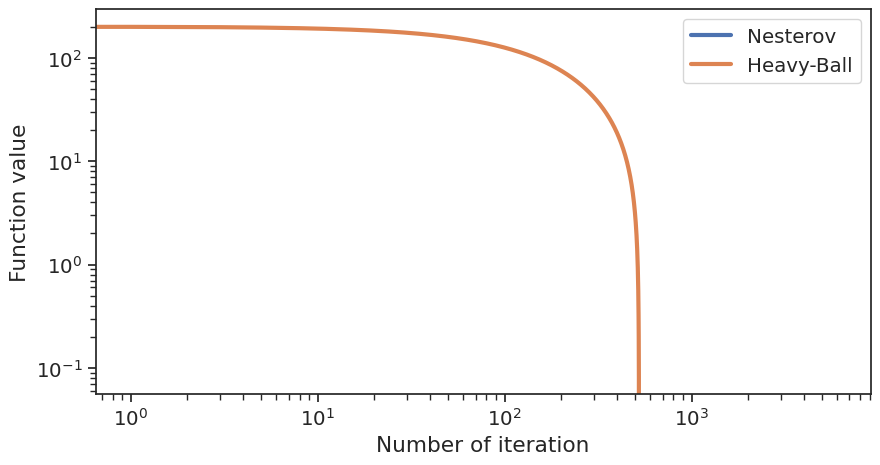

INFO: n = 10, condition number = 100
INFO: HB converge at 2992 iteration, min f(x) = -10.45405483324837
INFO: Nesterov converge at 59 iteration, min f(x) = -10.454105089280874


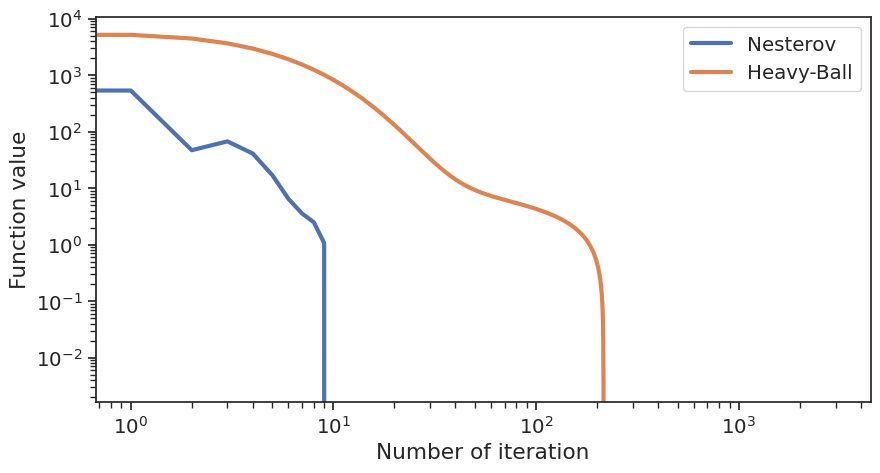

INFO: n = 10, condition number = 1000
INFO: HB converge at 1705 iteration, min f(x) = -11.289776873168748
INFO: Nesterov converge at 126 iteration, min f(x) = -11.291598010531038


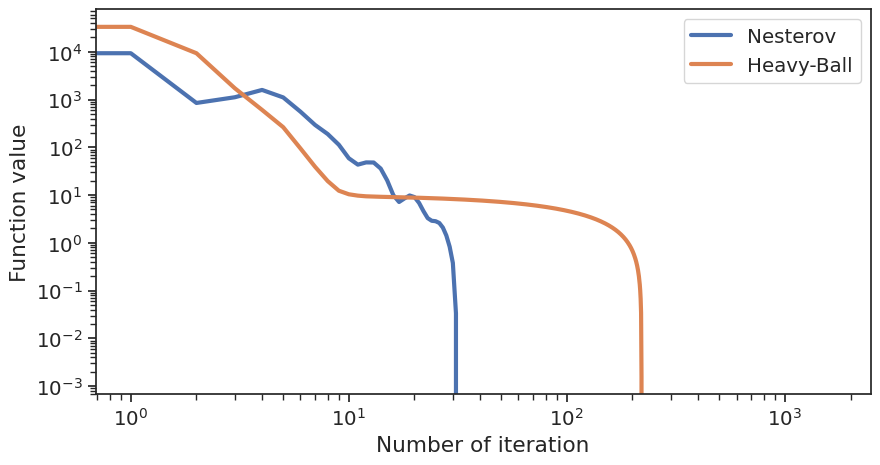

INFO: n = 1000, condition number = 1
INFO: HB converge at 5364 iteration, min f(x) = -2961.941984354705
INFO: Nesterov converge at 8 iteration, min f(x) = -2961.942221897887


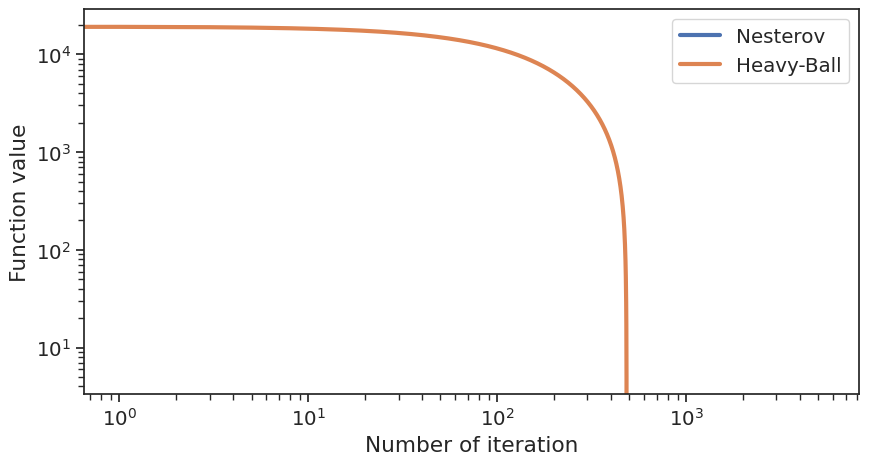

INFO: n = 1000, condition number = 100
INFO: HB converge at 1784 iteration, min f(x) = -202.00095899089897
INFO: Nesterov converge at 45 iteration, min f(x) = -202.10289648642404


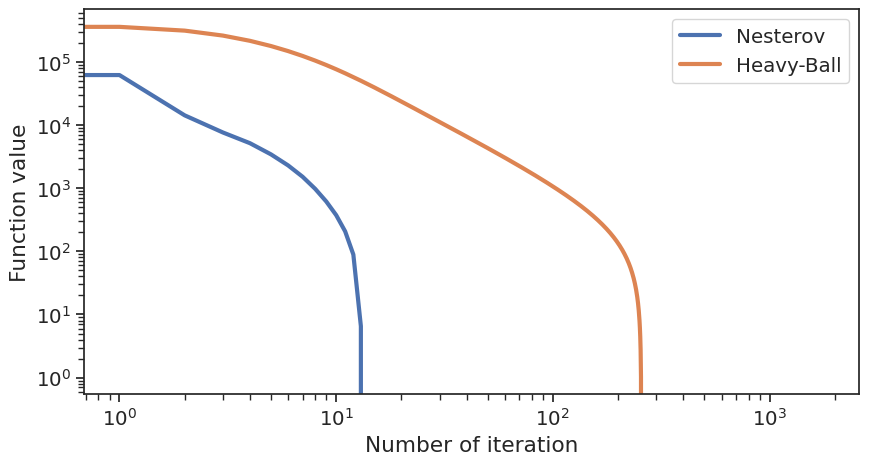

INFO: n = 1000, condition number = 1000
INFO: HB converge at 382 iteration, min f(x) = -21.06389628718201
INFO: Nesterov converge at 94 iteration, min f(x) = -30.319327628154532


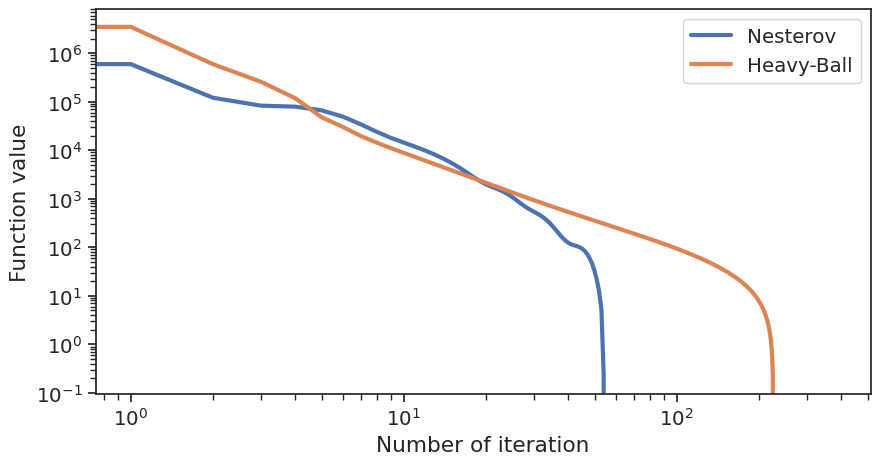

In [65]:
N = int(1e4)
eps = 1e-8

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(N, eps, alpha, beta, 
                                                   f_quadratic, grad_f_quadratic,
                                                   x0=x0, params=(A, b), 
                                                   verbose=False)
        
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                       f_quadratic, grad_f_quadratic,
                                                       x0=x0, params=(A, b),
                                                       verbose=False)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

3) eps = $10^{-12}$

INFO: n = 2, condition number = 1
INFO: HB converge at 9660 iteration, min f(x) = -20.194948401541648
INFO: Nesterov converge at 1 iteration, min f(x) = -20.194948401620056


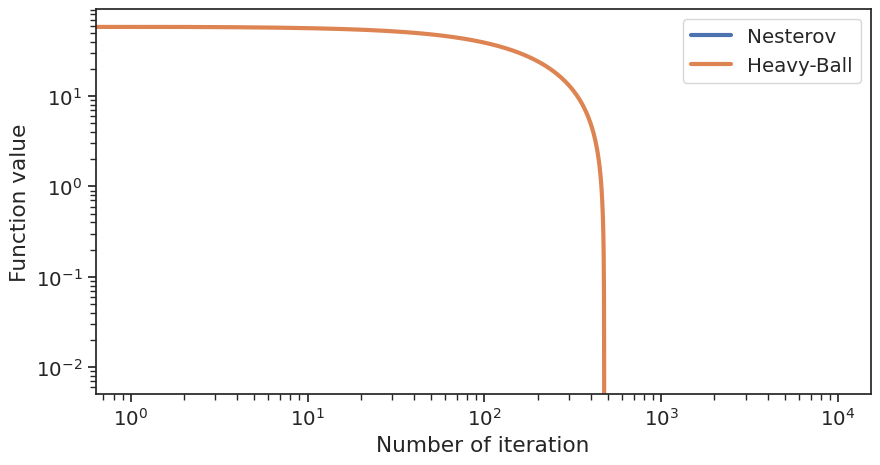

INFO: n = 2, condition number = 100
INFO: HB converge at 6609 iteration, min f(x) = -10.269506842470873
INFO: Nesterov converge at 114 iteration, min f(x) = -10.269506855847085


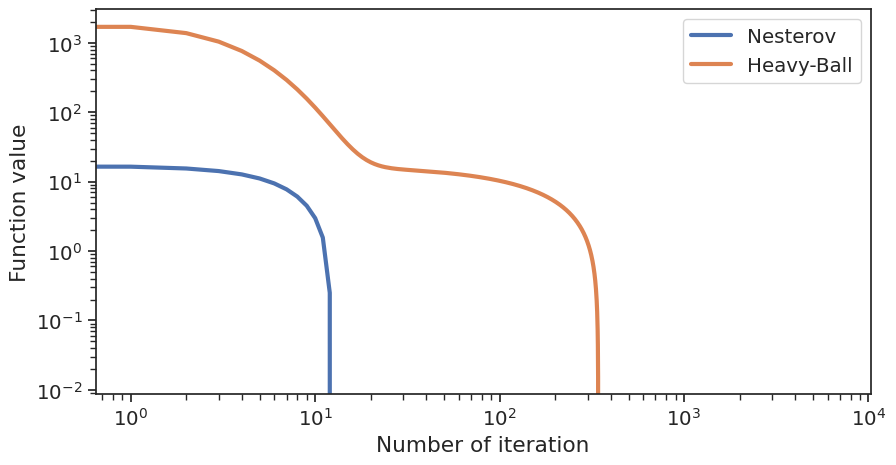

INFO: n = 2, condition number = 1000
INFO: HB converge at 4534 iteration, min f(x) = -0.40588414619717783
INFO: Nesterov converge at 273 iteration, min f(x) = -0.40588490790416937


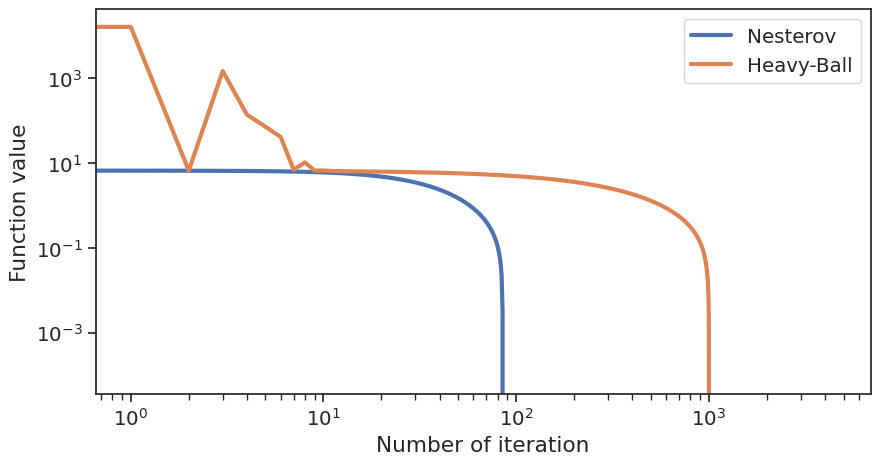

INFO: n = 10, condition number = 1
INFO: HB converge at 9044 iteration, min f(x) = -34.1504573871665
INFO: Nesterov converge at 12 iteration, min f(x) = -34.15045738744263


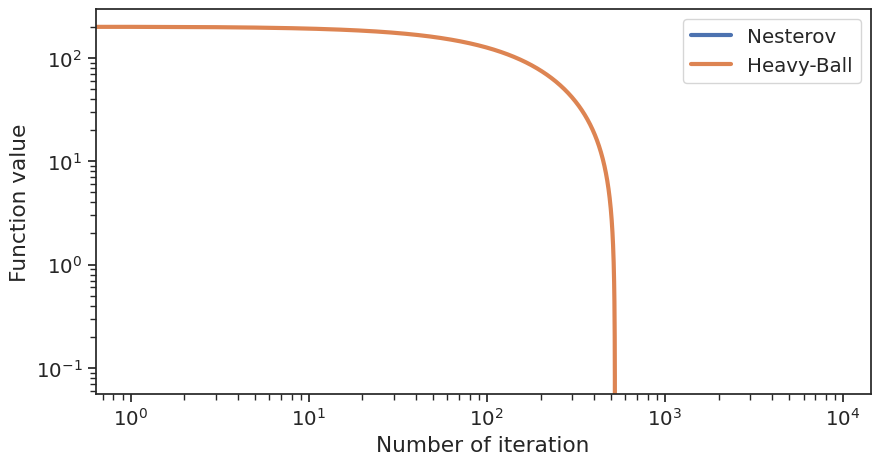

INFO: n = 10, condition number = 100
INFO: HB converge at 6212 iteration, min f(x) = -10.457762150416478
INFO: Nesterov converge at 108 iteration, min f(x) = -10.457762169726754


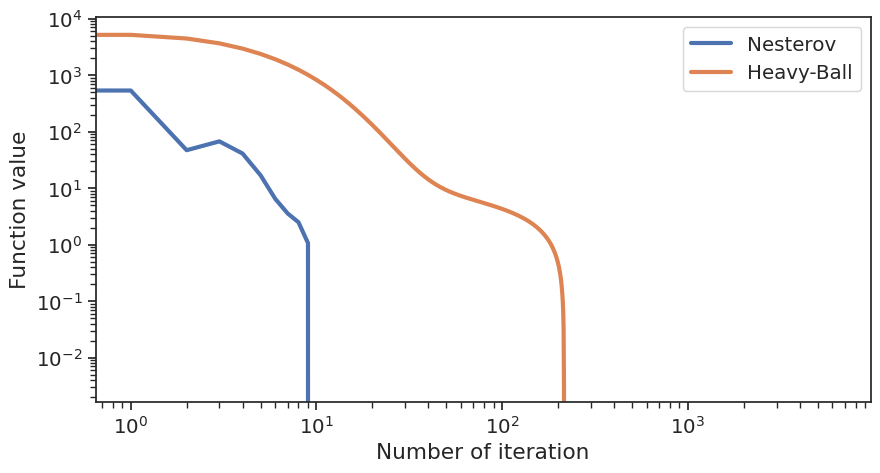

INFO: n = 10, condition number = 1000
INFO: HB converge at 4925 iteration, min f(x) = -11.453402552407788
INFO: Nesterov converge at 292 iteration, min f(x) = -11.453403012232766


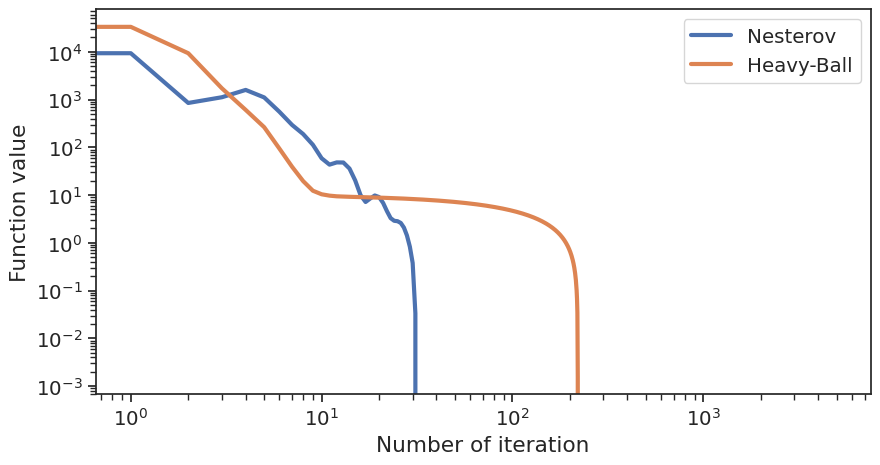

INFO: n = 1000, condition number = 1
INFO: HB converge at 8431 iteration, min f(x) = -2961.942299624286
INFO: Nesterov converge at 12 iteration, min f(x) = -2961.942299652012


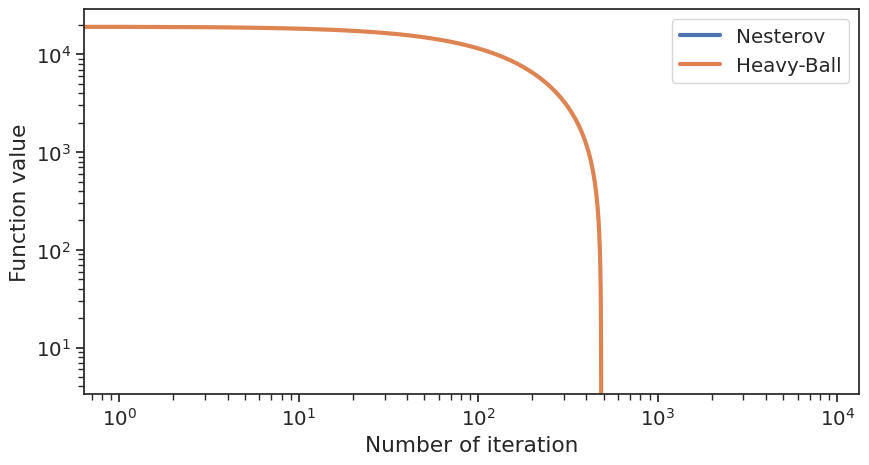

INFO: n = 1000, condition number = 100
INFO: HB converge at 4668 iteration, min f(x) = -202.1916671749623
INFO: Nesterov converge at 88 iteration, min f(x) = -202.19167490496056


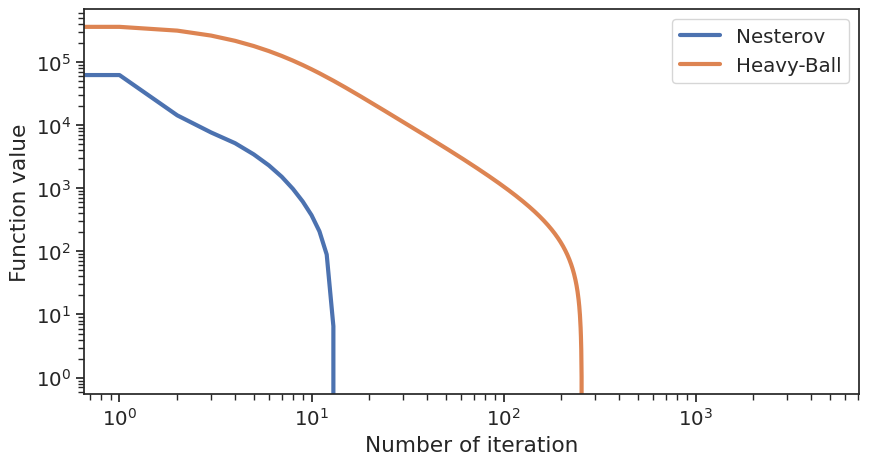

INFO: n = 1000, condition number = 1000
INFO: HB converge at 2843 iteration, min f(x) = -31.891034340452045
INFO: Nesterov converge at 207 iteration, min f(x) = -31.892373624520527


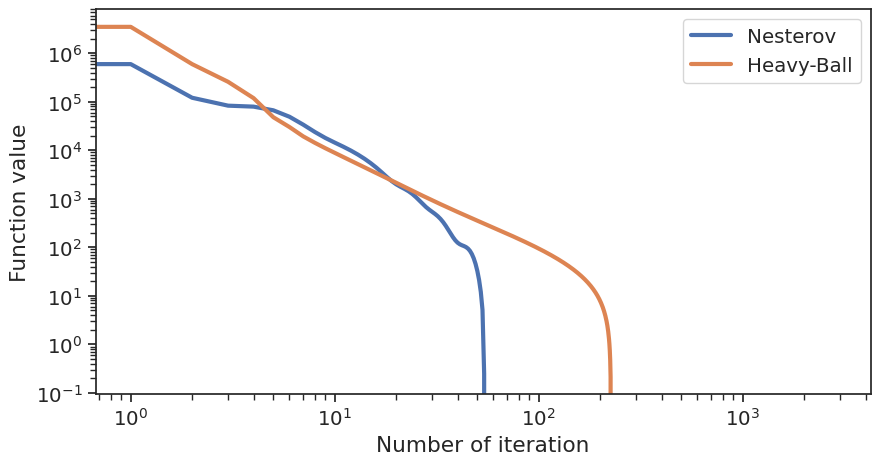

In [66]:
N = int(1e4)
eps = 1e-12

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(N, eps, alpha, beta, 
                                                   f_quadratic, grad_f_quadratic,
                                                   x0=x0, params=(A, b), 
                                                   verbose=False)
        
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                       f_quadratic, grad_f_quadratic,
                                                       x0=x0, params=(A, b),
                                                       verbose=False)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

Для плохообусловленных задач следует повышать требуемую точность.

При `n = 1000, cond_num = 1000` результаты работы метода Нестерова и метода тяжелого шарика совпадают только при высокой точности `eps = 1e-12`

### Разные начальные условия

In [67]:
n = 10
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

$$ x_0 = y_0 = 0_n $$

In [68]:
x0 = np.zeros(n)
y0 = np.zeros(n)

In [69]:
eps = 1e-8
      
f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    x0=x0, y0=y0,
                                                    params=(A, b),
                                                    verbose=False)

INFO: Nesterov converge at 27 iteration, min f(x) = -10.427283228090989


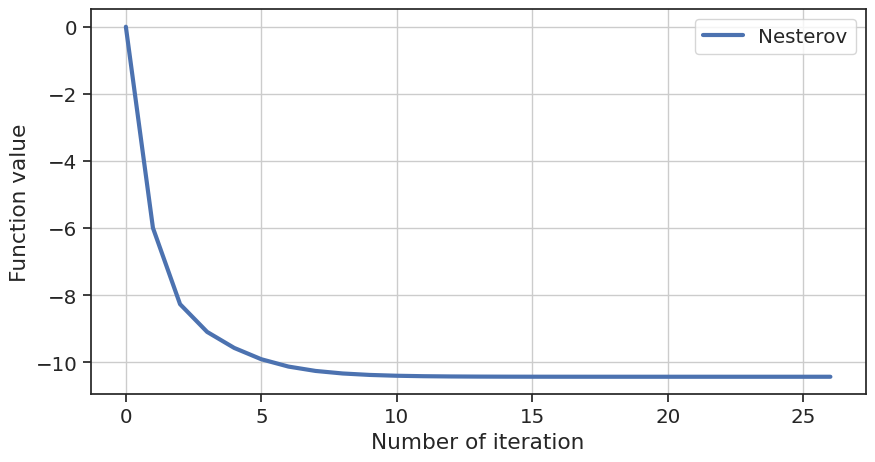

In [70]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')

$$ x_0 = 0_n, ~ y_0 = 1_n $$

In [71]:
x0 = np.zeros(n)
y0 = np.ones(n)

In [72]:
eps = 1e-8

f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(N, eps, 
                                                    f_quadratic, grad_f_quadratic,
                                                    x0=x0, y0=y0,
                                                    params=(A, b),
                                                    verbose=False)

INFO: Nesterov converge at 27 iteration, min f(x) = -10.427283228090989


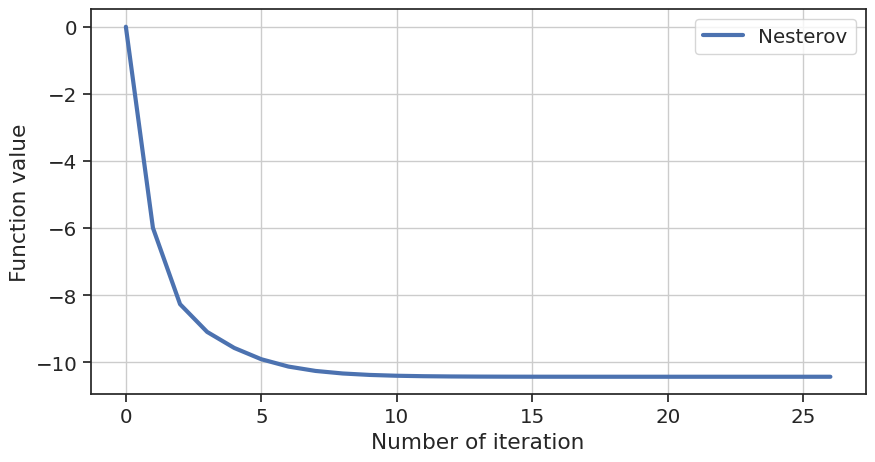

In [73]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')

Метод Нестерова работает одинаково для двух данных начальных условий

# End